In [29]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3.math as pmm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess, MCMCInterface
from starry_process.math import cho_factor, cho_solve
import starry_process 
import theano
import aesara_theano_fallback.tensor as tt
from theano.tensor.slinalg import cholesky
from corner import corner
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
from tqdm import tqdm
from theano.tensor.random.utils import RandomStream
import scipy.linalg as sl
import scipy.stats as ss

starry.config.quiet = True
np.random.seed(1)

In [7]:
def _cho_solve(L, b):
    return tt.slinalg.solve_upper_triangular(L.T, tt.slinalg.solve_lower_triangular(L, b))

class StarryStarryProcess(object):
    def __init__(self, sys, sp, nt, nlm):
        self._sys = sys
        self._sp = sp
        self._nt = nt
        self._nlm = nlm

        self._mu = sp.mean_ylm
        self._Lambda = sp.cov_ylm

    @property
    def nt(self):
        return self._nt
    @property
    def nlm(self):
        return self._nlm

    @property
    def sys(self):
        return self._sys
    @property
    def sp(self):
        return self._sp
    
    @property
    def mu(self):
        return self._mu
    @property
    def Lambda(self):
        return self._Lambda
    
    @property
    def primary(self):
        return self.sys.primary
    @property
    def secondary(self):
        return self.sys.secondaries[0]
    
    @property
    def design_matrix(self):
        return self._M

    @property
    def logl_marginal(self):
        return self._logl_marginal
    @property
    def a(self):
        return self._a
    @property
    def AInv_chol(self):
        return self._AInv_chol

    def _compute(self, t, flux, sigma_flux):
        M = self.sys.design_matrix(t)[:,:-1] # We don't use any flux from the secondary, so [:, :-1]
        self._M = M

        nlm = self.nlm
        nt = self.nt

        mu = self.mu
        Lambda = self.Lambda

        # We want to enforce that the prior on the constant term in the map is
        # completely flat, so we set the first row and column of the precision
        # matrix to zero we do this manually here.  First we Cholesky decompose:
        #
        # Lambda[1:,1:] = L L^T
        #
        # Then, because of a quirk of theano (no gradients for `cho_solve!`,
        # WTF), we can compute Lambda[1:,1:]^{-1} via
        #
        # Lambda[1:,1:]^{-1} = tt.slinalg.solve_triangular(L.T, tt.slinalg.solve_triangular(L, tt.eye(nlm-1), lower=True), lower=False)
        #
        # encapsulated in our _cho_solve(...) function above
        L = tt.slinalg.cholesky(Lambda[1:,1:])
        Lambda_inv = _cho_solve(L, tt.eye(nlm-1))
        Lambda_inv = tt.set_subtensor(tt.zeros((nlm, nlm))[1:,1:], Lambda_inv)

        sigma_flux2 = tt.square(sigma_flux)
        MTCinv = M.T / sigma_flux2[None, :]
        MTCinvM = tt.dot(MTCinv, M)

        AInv = Lambda_inv + MTCinvM
        AInv_chol = tt.slinalg.cholesky(AInv)
        a = _cho_solve(AInv_chol, tt.dot(Lambda_inv, mu) + tt.dot(MTCinv, flux))

        self._a = a
        self._AInv_chol = AInv_chol

        b = tt.dot(M, mu)
        r = flux - b

        Cinvr = r / sigma_flux2

        rtilde = Cinvr - tt.dot(MTCinv.T, tt.slinalg.solve(AInv, tt.dot(MTCinv, r)))

        # Identity:
        # |B| = |I + M^T C^-1 M L| |C| = |L^-1 + M^T C^-1 M| |L| |C|
        # But we want to cancel the infinite constant in L[0,0], so we ignore the first row and column of L:
        # |B| = | A^-1 | |L[1:,1:]| |C|

        logdetB = tt.sum(tt.log(sigma_flux2)) + 2*tt.sum(tt.log(tt.diag(AInv_chol))) + 2*tt.sum(tt.log(tt.diag(L)))

        # (nt-1) because we have cancelled one dimension due to the flat prior on the [0,0] constant term.
        logl = -0.5*tt.dot(r, rtilde) - 0.5*logdetB - 0.5*(nt-1)*tt.log(2*np.pi)
        self._logl_marginal = logl

    def marginal_likelihood(self, t, flux, sigma_flux):
        self._compute(t, flux, sigma_flux)
        return self.logl_marginal
    
    def sample_ylm_conditional(self, t, flux, sigma_flux, size=1, rng=None):
        if rng is None:
            rng = RandomStream(seed=np.random.randint(1<<32))

        nylm = self.nlm

        self._compute(t, flux, sigma_flux)
        return self.a[None,:] + tt.slinalg.solve_upper_triangular(self.AInv_chol.T, rng.normal(size=(nylm, size))).T

## Helper functions

In [2]:
def Inclination(name, testval=30):
    """
    An isotropic distribution for inclination angles (in degrees).
    
    """
    def logp(x):
        return tt.log(np.pi / 180 * tt.sin(x * np.pi / 180))

    def random(*args, **kwargs):
        return tt.arccos(pm.Uniform.dist(0, 1).random(*args, **kwargs)) * 180 / np.pi

    return pm.DensityDist(
        name,
        logp,
        random=random,
        initval=testval,
    )


def Angle(*args, **kwargs):
    """
    A uniform distribution for angles in [-180, 180).
    
    """
    if kwargs.get("testval", None) is not None:
        kwargs["testval"] *= np.pi / 180
    return 180 / np.pi * pmx.Angle(*args, **kwargs)


# Shorthand for the usual Uniform distribution
Uniform = pm.Uniform

In [39]:
def generate(t, params, seed=1, error=1e-4, visualize=True):
    """
    Generate a synthetic light curve.
    
    """
    rng = np.random.default_rng(302592346730275158208684369480422136411)
    # Set up the system
    map = starry.Map(15, 2)
    map.inc = params["star.inc"]["truth"]
    map.obl = params["star.obl"]["truth"]
    map[1] = params["star.u1"]["truth"]
    map[2] = params["star.u2"]["truth"]
    star = starry.Primary(map, r=params["star.r"]["truth"], m=params["star.m"]["truth"], prot=params["star.prot"]["truth"]) 
    planet = starry.Secondary(
        starry.Map(0,0),
        inc=params["planet.inc"]["truth"],
        ecc=params["planet.ecc"]["truth"],
        Omega=params["planet.Omega"]["truth"],
        porb=params["planet.porb"]["truth"],
        t0=params["planet.t0"]["truth"],
        r=params["planet.r"]["truth"],
        m=params["planet.m"]["truth"],
        prot=1.0
    )

    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]
    theta = (360 * t / params["star.prot"]["truth"]) % 360
    
    # *** Draw 1 sample from the GP
    sp = StarryProcess(
        mu=params["gp.mu"]["truth"],
        sigma=params["gp.sigma"]["truth"],
        r=params["gp.r"]["truth"],
        dr=params["gp.dr"]["truth"],
        c=params["gp.c"]["truth"],
        n=params["gp.n"]["truth"],
    )

    nt = len(t)
    ssp = StarryStarryProcess(sys, sp, nt, len(star.map.y.eval()))
    print(len(star.map.y.eval()))
    
    y_true = sp.sample_ylm().eval().reshape(-1)
    y_true[0] += 1
    
    # Compute the light curve
    flux_true = sys.design_matrix(t).eval()[:, :-1] @ y_true
    sigma_flux = error*np.ones_like(flux_true)

    flux_obs = flux_true + sigma_flux*rng.normal(size=nt)
    
    # Visualize the system
    if visualize:
        fig, ax = plt.subplots(1, 2, figsize=(20, 8))
        idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
        ax[0].plot(xo[idx], yo[idx], "k.", ms=1);
        ax[0].set_aspect(1)
        ax[0].axis("off")
        map[:, :] = y_true
        map.show(ax=ax[0])
        ax[0].set_ylim(-3, 3)
        idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)
        lat = 180 / np.pi * np.arcsin(yo[idx])
        lon = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
        lon = (lon + 180) % 360 - 180
        mask = np.append(np.array(lon[1:] > lon[:-1], dtype=float), 0)
        mask[mask == 1] = np.nan
        map.show(ax=ax[1], projection="rect")
        ax[1].plot(lon, lat + mask, "k-");
    
    return flux_obs, flux_true, sigma_flux, ssp, sp, y_true

In [229]:
def gp_model(t, flux, err, params):

    Ttotal = t[-1] - t[0]
    prot_frac_bounds = min(params['star.prot']['truth']/Ttotal/2, 0.25)
    porb_frac_bounds = min(params['planet.porb']['truth']/Ttotal/2, 0.25)

    t0_bounds = 0.2 # Hard coded!

    a = (params['star.m']['truth']*np.square(params['planet.porb']['truth']/365.25))**(1/3) * 215.03 # Solar radii
    bmax = params['star.r']['truth'] / a

    # Helper function to instantiate parameters
    def parameter(name):
        param = params[name]
        if param.get("free", False):
            args = param.get("args", [])
            kwargs = param.get("kwargs", {})
            testval = param.get("testval", param["truth"])
            return param["dist"](name, *args, testval=testval, **kwargs)
        else:
            return param["truth"]
    
    
    starry.config.lazy = True
    
    with pm.Model() as model:

        # log_prot = pm.Uniform('log_prot', np.log(parameter('star.prot')) + np.log1p(-prot_frac_bounds), np.log(parameter('star.prot')) + np.log1p(prot_frac_bounds))
        # prot = pm.Deterministic('prot', tt.exp(log_prot))
        prot = parameter('star.prot')

        # log_porb = pm.Uniform('log_porb', np.log(parameter('planet.porb')) + np.log1p(-porb_frac_bounds), np.log(parameter('planet.porb')) + np.log1p(porb_frac_bounds))
        # porb = pm.Deterministic('porb', tt.exp(log_porb))
        porb = parameter('planet.porb')

        t0 = pm.Uniform('planet.t0', -t0_bounds, t0_bounds)
        # t0 = parameter('planet.t0')

        # log_rp = pm.Uniform('log_rp', np.log(parameter('planet.r')/2), np.log(2*parameter('planet.r')))
        # rp = pm.Deterministic('rp', tt.exp(log_rp))
        rp = parameter('planet.r')

        # stellar_ori_x = pm.Normal('stellar_ori_x', mu=0, sigma=1, testval=1)
        # stellar_ori_y = pm.Normal('stellar_ori_y', mu=0, sigma=1, testval=1)
        # stellar_ori_z = pm.Normal('stellar_ori_z', mu=0, sigma=1, testval=1)
        # stellar_obl = pm.Deterministic('stellar_obl', 180.0/np.pi*tt.arctan2(stellar_ori_y, stellar_ori_x))
        # stellar_inc = pm.Deterministic('stellar_inc', 180.0/np.pi*tt.arccos(stellar_ori_z / tt.sqrt(tt.square(stellar_ori_x) + tt.square(stellar_ori_y) + tt.square(stellar_ori_z))))
        stellar_obl = parameter('star.obl')
        stellar_inc = parameter('star.inc')

        # Impact parameter
        # b = pm.Uniform('b', -bmax, bmax)
        # planet_inc = pm.Deterministic('planet_inc', 180.0/np.pi*np.arccos(b))
        planet_inc = parameter('planet.inc')

        pri_model = starry.Primary(starry.Map(ydeg=15, udeg=2, inc=stellar_inc, obl=stellar_obl), r=parameter('star.r'), m=parameter('star.m'), prot=prot, t0=0.0)
        pri_model.map[1] = parameter('star.u1')
        pri_model.map[2] = parameter('star.u2')

        sec_model = starry.Secondary(starry.Map(0,0), 
                          t0=t0, r=rp, m=parameter('planet.m'), prot=1,
                          porb=porb, ecc=parameter('planet.ecc'), Omega=0, inc=planet_inc)
    
        sys_model = starry.System(pri_model, sec_model)

        # Instantiate the GP
        sp_model = StarryProcess(
            mu=parameter("gp.mu"),
            sigma=parameter("gp.sigma"),
            r=parameter("gp.r"),
            dr=parameter("gp.dr"),
            c=parameter("gp.c"),
            n=parameter("gp.n"),
            ydeg=15,
            udeg=2,
            marginalize_over_inclination=False,  
        )

        ssp_model = StarryStarryProcess(sys_model, sp_model, len(t), 256)

        pm.Potential('marginal_likelihood', ssp_model.marginal_likelihood(t, flux, err))
        
        return model

## Generate a light curve

In [71]:
0.04*0.683

0.027320000000000004

256


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


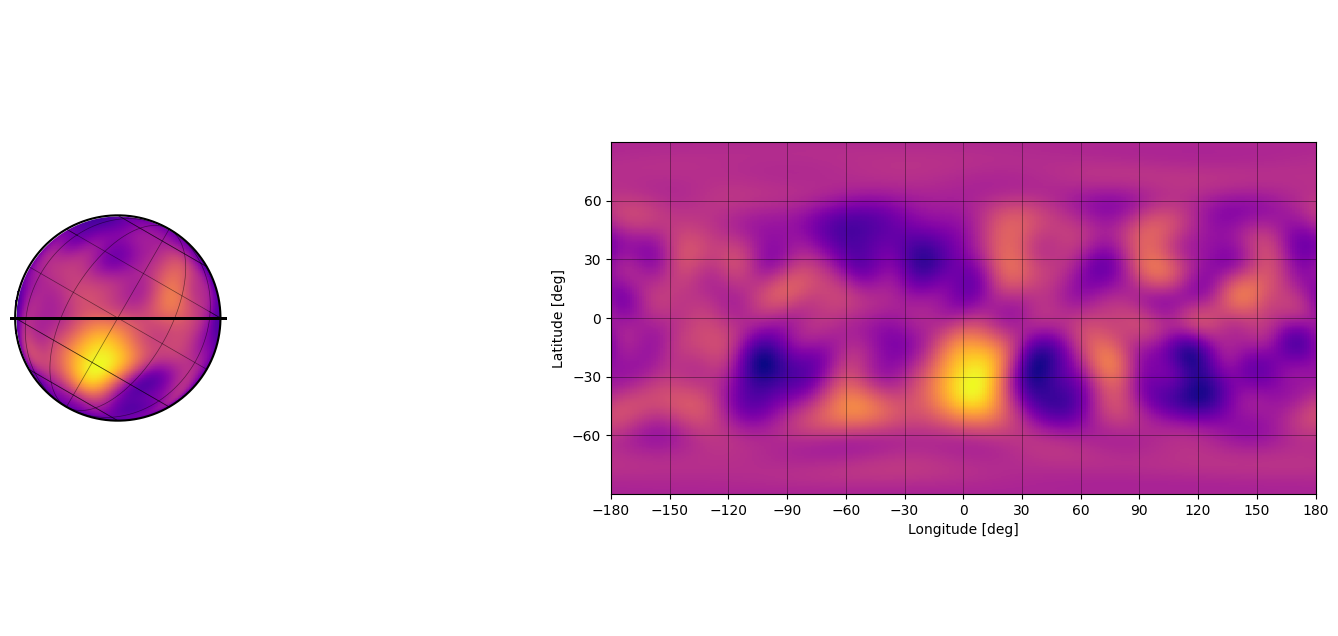

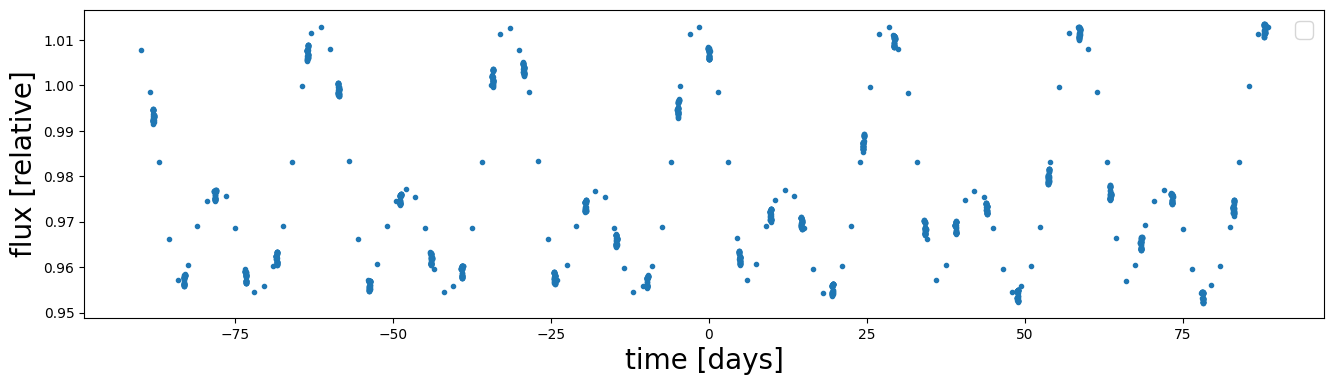

In [230]:
# *** True parameters & priors
params = {
    "planet.inc": {"truth": 90.0, "dist": Inclination},
    "planet.ecc": {"truth": 0.0, "dist": Uniform, "args": [0.0, 0.4]},
    "planet.Omega": {"truth": 0.0, "dist": Angle},
    "planet.porb": {"truth": 4.887802443, "dist": Uniform, "args": [4.8, 4.9]},
    "planet.t0": {"truth": 0.0, "dist": Uniform, "args": [-0.2, 0.2]},
    "planet.r": {"truth": 0.04*0.683, "dist": Uniform, "args": [0.01, 0.03]},
    "planet.m": {"truth": 1e-3*0.81, "dist": Uniform, "args": [0.0001, 0.001]},
    "star.inc": {"truth": 90, "dist": Inclination},
    "star.m": {"truth": 0.81, "dist": Uniform, "args": [0.4, 1]},
    "star.u1": {"truth": 0.4, "dist": Uniform, "args": [0.0, 0.6]},
    "star.u2": {"truth": 0.26, "dist": Uniform, "args": [0.0, 0.4]},
    "star.prot": {"truth": 30, "dist": pm.Uniform, "args": [1, 50]},
    "star.obl": {"truth": -30, "dist": Angle},
    "star.r": {"truth": 0.683, "dist": Uniform, "args": [0.1, 1]},
    "gp.r": {"truth": 20, "dist": Uniform, "args": [5.0, 25.0]},
    "gp.dr": {"truth": 5.0, "dist": Uniform, "args": [1.0, 10.0]},
    "gp.c": {"truth": 0.5, "dist": Uniform, "args": [0.01, 1]},
    "gp.n": {"truth": 1, "dist": Uniform, "args": [0, 10]},
    "gp.mu": {"truth": 30, "dist": Uniform, "args": [0.0, 80.0]},
    "gp.sigma": {"truth": 5, "dist": Uniform, "args": [1.0, 10]}
}

Ttr_half = 0.1
dt_in_transit = Ttr_half / 20.0
dt_out_transit = params['star.prot']['truth'] / 20.0

T = 3*params['star.prot']['truth']
t_in = np.arange(-T, T, dt_in_transit)
t_out = np.arange(-T, T, dt_out_transit)

t_in_transit = (t_in % params['planet.porb']['truth'] < Ttr_half) | (t_in % params['planet.porb']['truth'] > params['planet.porb']['truth']-Ttr_half)
t_out_transit = (t_out % params['planet.porb']['truth'] < Ttr_half) | (t_out % params['planet.porb']['truth'] > params['planet.porb']['truth']-Ttr_half)

t = np.sort(np.concatenate((
    t_in[t_in_transit],
    t_out[~t_out_transit],
)))
nt = len(t)

# Get the light curve
flux_obs, flux_true, sigma_flux, ssp, sp, y_true = generate(t, params, error=1e-4)

# Plot the data
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.errorbar(t, flux_obs, yerr=sigma_flux, fmt='.')
ax.set_ylabel("flux [relative]", fontsize=20)
ax.set_xlabel("time [days]", fontsize=20)
ax.legend(fontsize=16);

<ErrorbarContainer object of 3 artists>

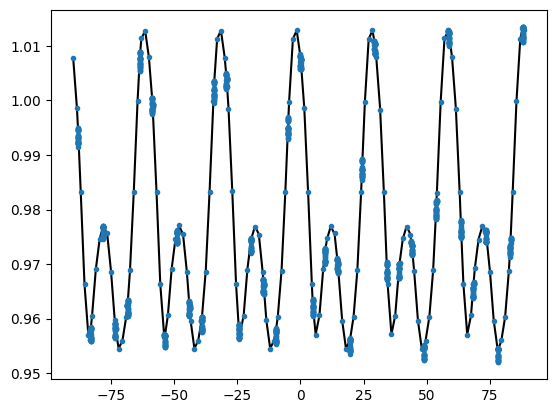

In [93]:
plt.plot(t, flux_true, color='k')
plt.errorbar(t, flux_obs, yerr=sigma_flux, fmt='.')

/Users/sabina/Desktop/GitHub/starry_process/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


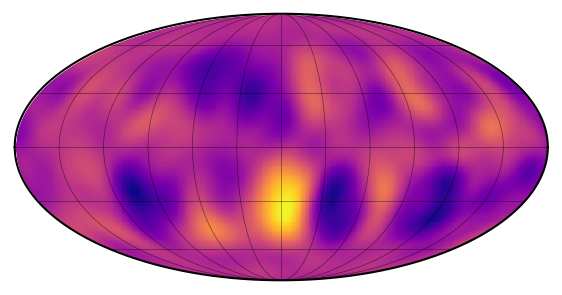

In [231]:
sp.visualize(y_true)

<ErrorbarContainer object of 3 artists>

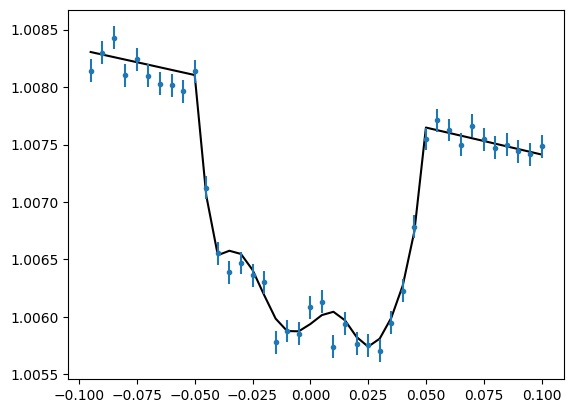

In [95]:
sel = np.abs(t) < 1/10
plt.plot(t[sel], flux_true[sel], color='k')
plt.errorbar(t[sel], flux_obs[sel], yerr=sigma_flux[sel], fmt='.')

In [96]:
ylm_draw = ssp.sample_ylm_conditional(t, flux_obs, sigma_flux).eval()[0,:]

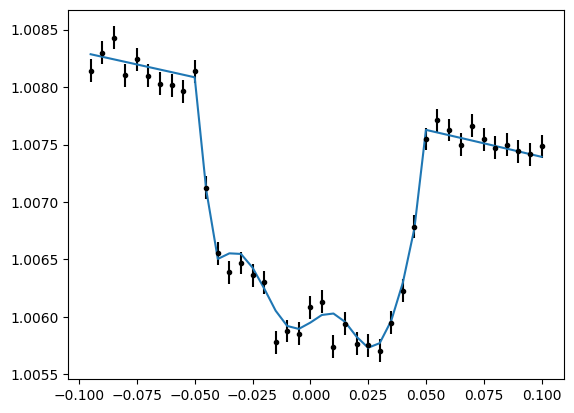

In [97]:
plt.errorbar(t[sel], flux_obs[sel], yerr=sigma_flux[sel], fmt='.', color='k')
plt.plot(t[sel], (ssp.design_matrix.eval() @ ssp.a.eval())[sel])

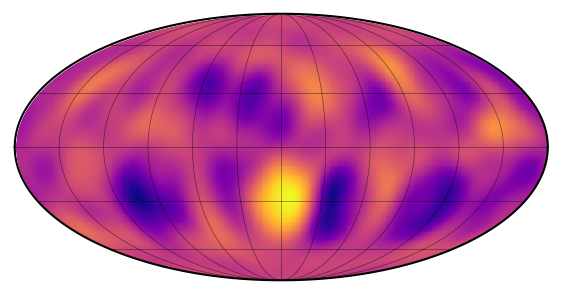

In [98]:
sp.visualize(ylm_draw)

In [30]:
resid = flux_obs - ssp.design_matrix.eval() @ ylm_draw
np.sum(ss.norm(loc=0, scale=sigma_flux).logpdf(resid)) - 0.5*np.dot(ylm_draw[1:] - sp.mean_ylm.eval()[1:], np.linalg.solve(sp.cov_ylm.eval()[1:,1:], ylm_draw[1:] - sp.mean_ylm.eval()[1:])) - 0.5*np.linalg.slogdet(sp.cov_ylm.eval()[1:,1:])[1] - 0.5*(len(ylm_draw)-1)*np.log(2*np.pi)

13599.716787808335

In [31]:
whitened_ylm_resid = np.dot(ssp.AInv_chol.T.eval(), ylm_draw - ssp.a.eval())
ssp.marginal_likelihood(t, flux_obs, sigma_flux).eval() - 0.5*np.dot(whitened_ylm_resid, whitened_ylm_resid) + np.sum(np.log(np.diag(ssp.AInv_chol.eval()))) - 0.5*len(ylm_draw)*np.log(2*np.pi)

13599.716828178713

In [32]:
ssp.marginal_likelihood(t, flux_obs, sigma_flux).eval()

array(12245.33202028)

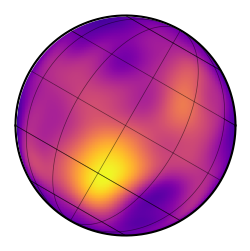

In [33]:
map = starry.Map(15, udeg=2)
map.inc = params["star.inc"]["truth"]
map.obl = params["star.obl"]["truth"]
map[1] = params["star.u1"]["truth"]
map[2] = params["star.u2"]["truth"]
map[:,:] = y_true
map.show()

# Inference

In [83]:
# Set some free params & get the model
p = dict(params)

p['star.prot']['free'] = True
p['star.obl']['free'] = True
p['star.inc']['free'] = True
p['planet.porb']['free'] = True
p['planet.t0']['free'] = True
p['planet.r']['free'] = True
p['planet.inc']['free'] = True

free = [x for x in p.keys() if p[x].get("free", False)]
model = gp_model(t, flux_obs, sigma_flux, p)

In [84]:
free

['planet.inc',
 'planet.porb',
 'planet.t0',
 'planet.r',
 'star.inc',
 'star.prot',
 'star.obl']

# NUTS

In [85]:
# Optimize
with model:
    map_soln = pmx.optimize()
    for x in free:
        print(f"{x}: {map_soln[x]} {[params[x]['truth']]}")


planet.inc: 89.98600674726778 [90.0]
planet.porb: 4.887804292101872 [4.887802443]
planet.t0: -2.1907770535317672e-05 [0.0]
planet.r: 0.0272265848186818 [0.027320000000000004]
star.inc: 90.0 [90]
star.prot: 29.999189003492674 [30]
star.obl: -0.5377551100598065 [-30]


message: Desired error not necessarily achieved due to precision loss.
logp: 12229.540889738251 -> 12252.67923113952


In [86]:
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        chains=1,
        cores=4,
        target_accept=0.9,
        return_inferencedata=False,
    )

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 9703 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


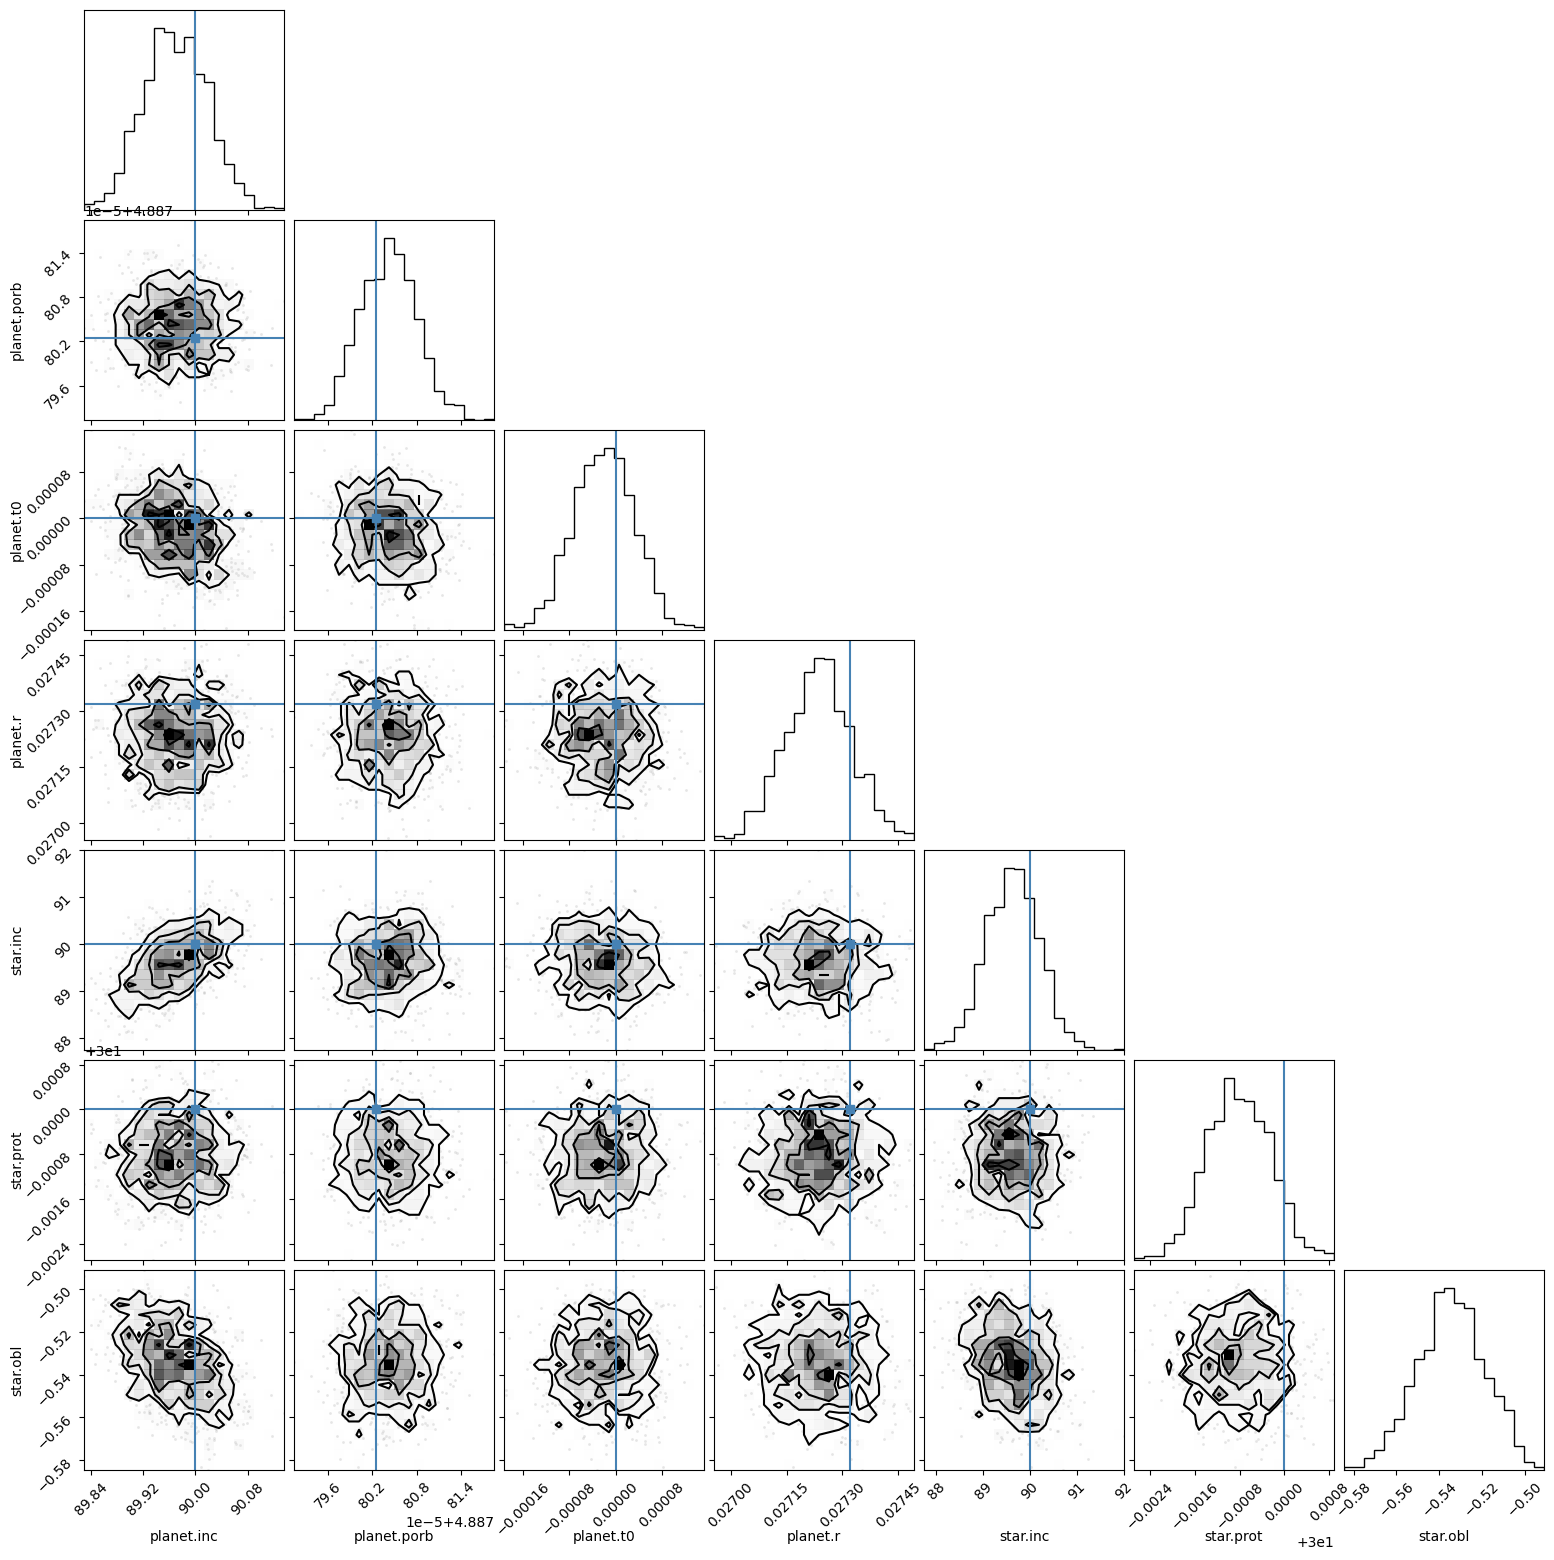

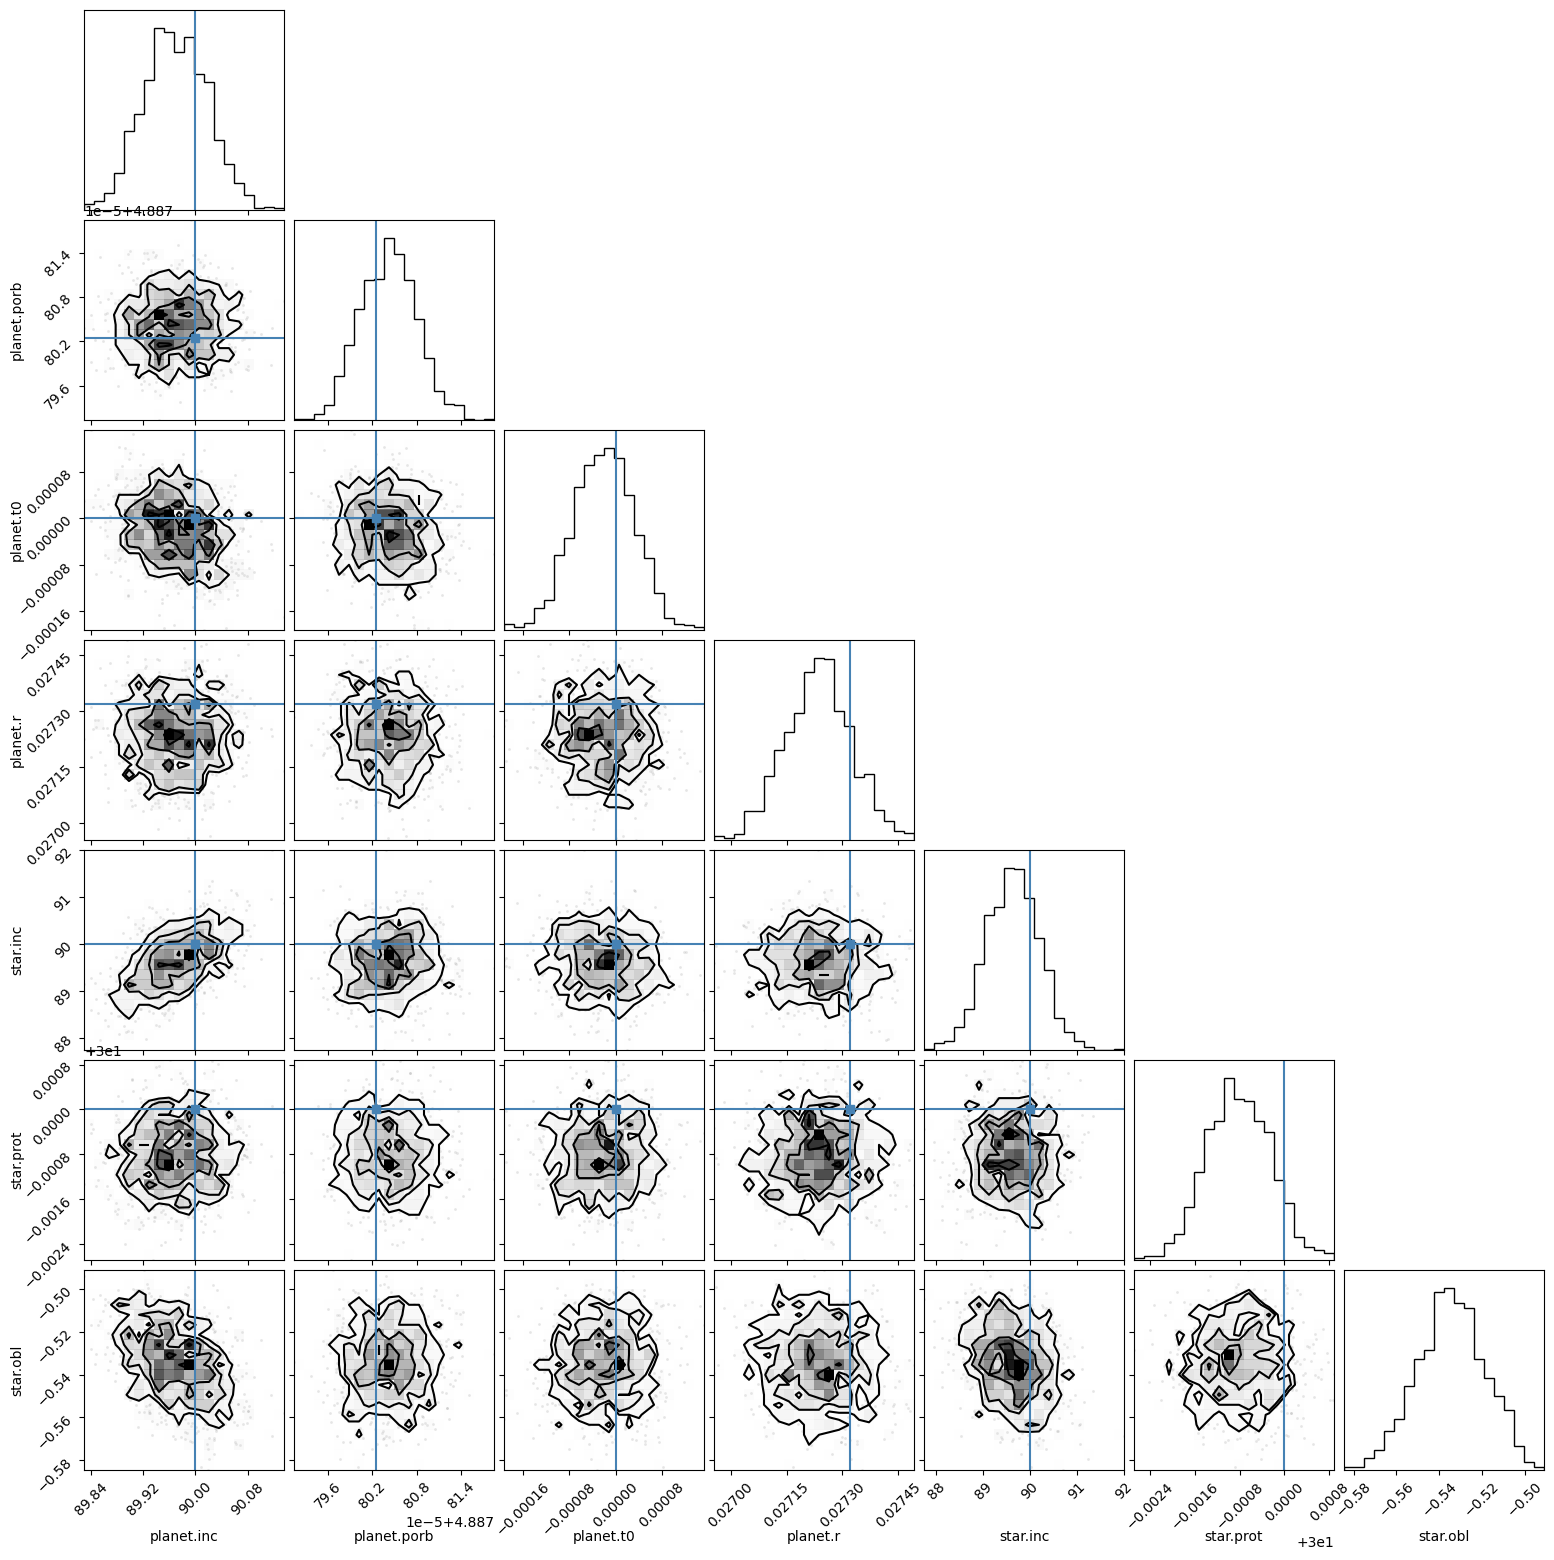

In [87]:
samples = pm.trace_to_dataframe(trace,varnames=free)
corner(np.array(samples),labels=free,truths=[params[x]['truth'] for x in free])

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/envs/starry-test/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'planet.inc'}>,
        <Axes: title={'center': 'planet.inc'}>],
       [<Axes: title={'center': 'planet.porb'}>,
        <Axes: title={'center': 'planet.porb'}>],
       [<Axes: title={'center': 'planet.t0'}>,
        <Axes: title={'center': 'planet.t0'}>],
       [<Axes: title={'center': 'planet.r'}>,
        <Axes: title={'center': 'planet.r'}>],
       [<Axes: title={'center': 'star.inc'}>,
        <Axes: title={'center': 'star.inc'}>],
       [<Axes: title={'center': 'star.prot'}>,
        <Axes: title={'center': 'star.prot'}>],
       [<Axes: title={'center': 'star.obl'}>,
        <Axes: title={'center': 'star.obl'}>]], dtype=object)

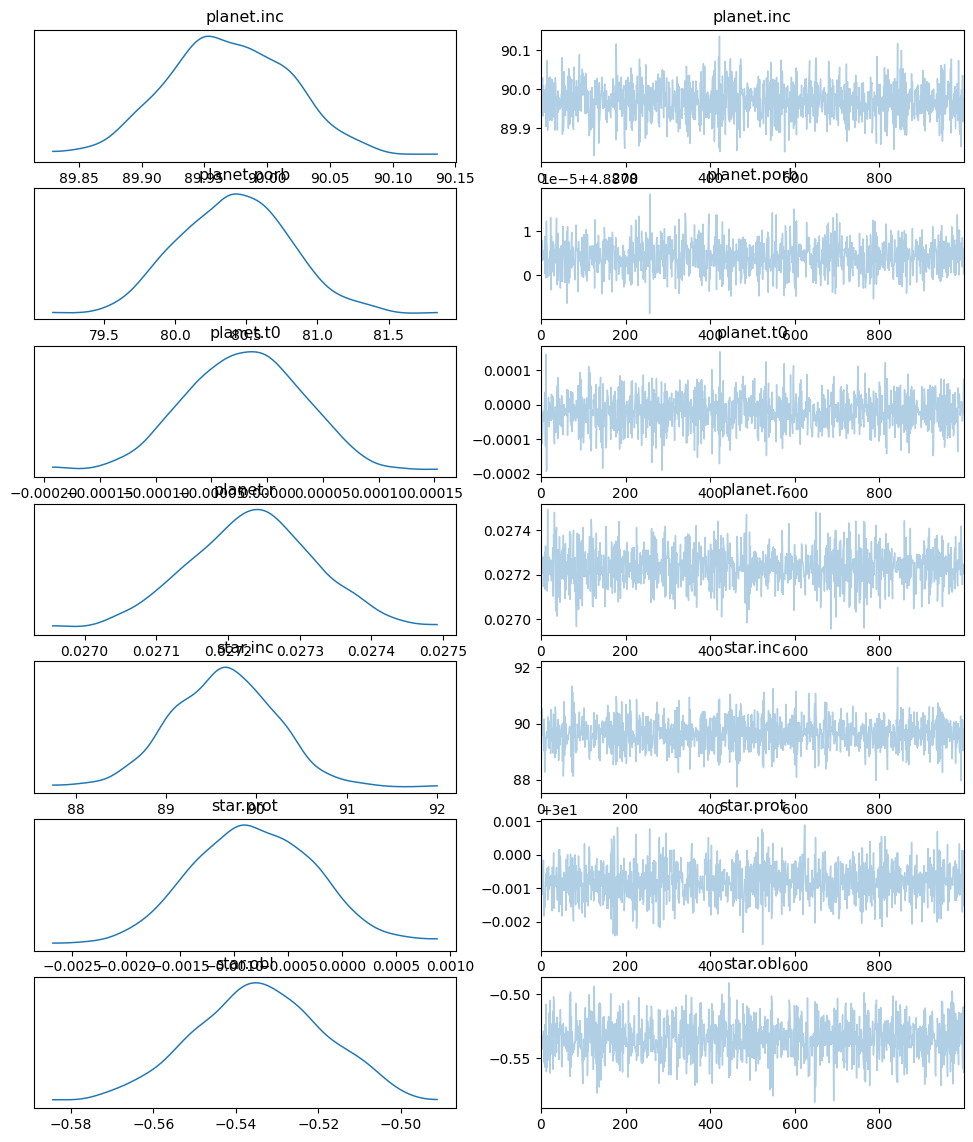

In [88]:
import arviz as az
az.plot_trace(trace,var_names=free)

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/envs/starry-test/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


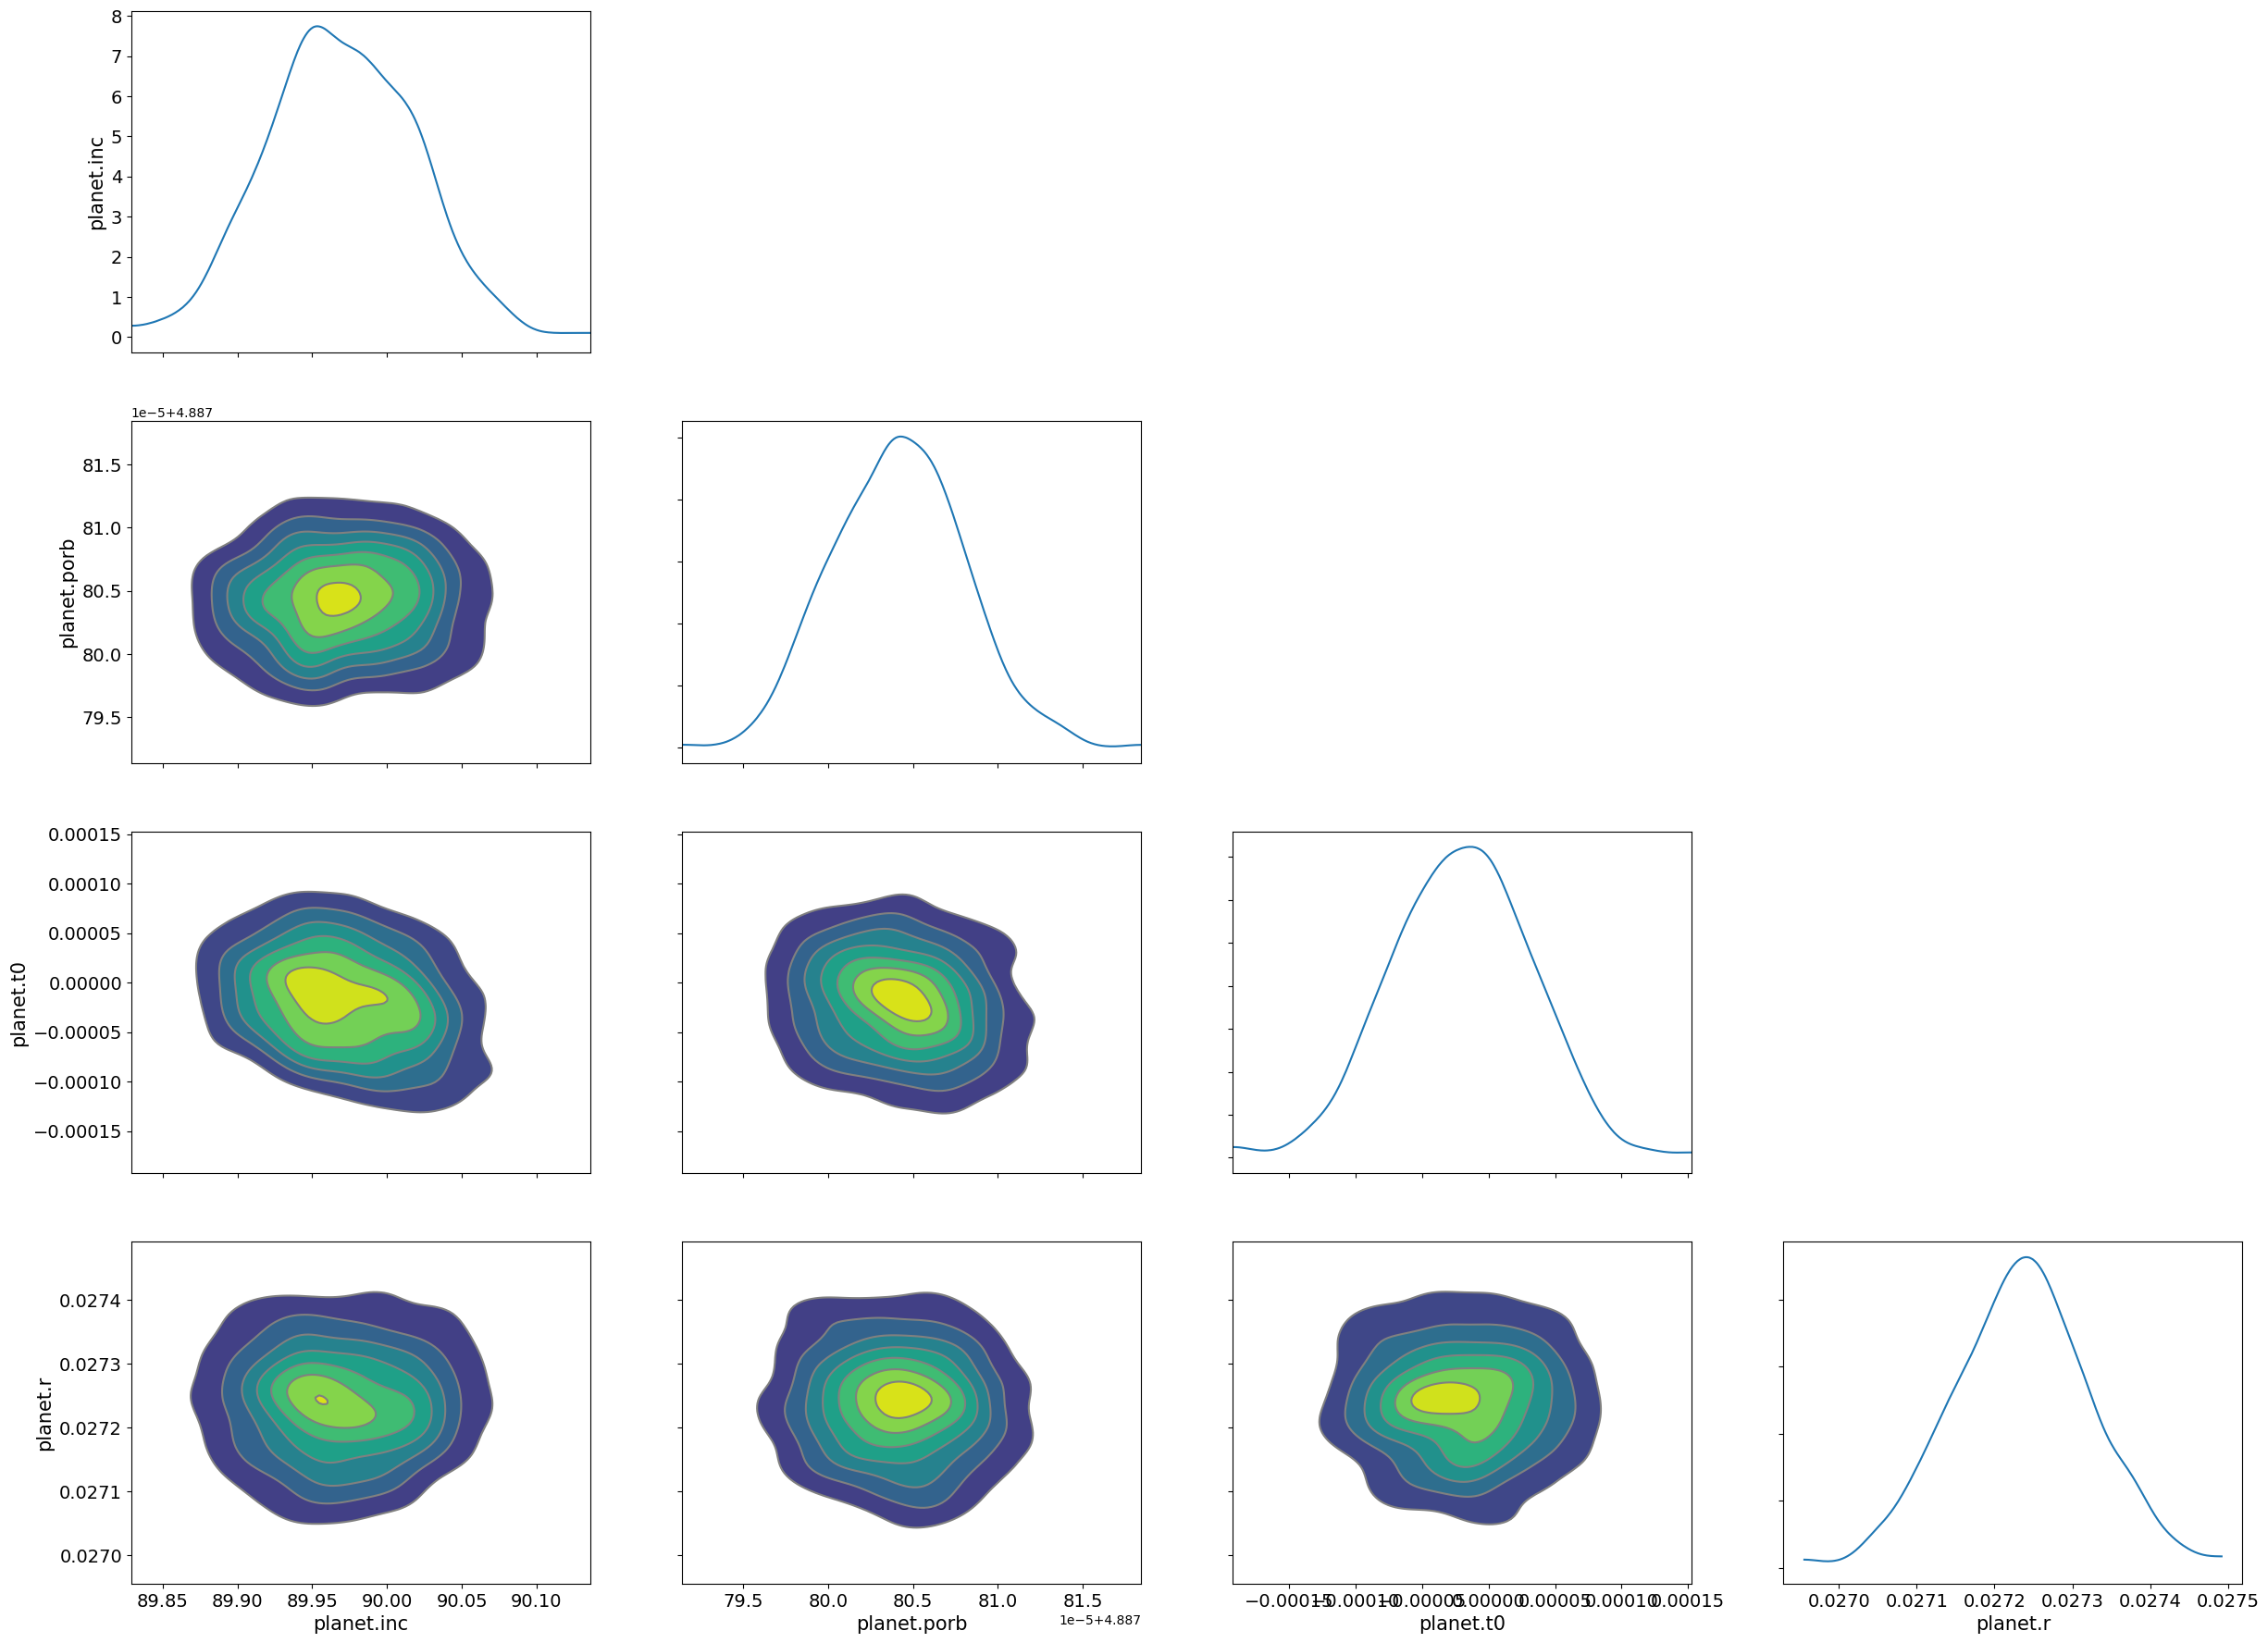

In [89]:
grid = az.plot_pair(trace, var_names=['planet.inc',
 'planet.porb',
 'planet.t0',
 'planet.r'], kind='kde', marginals=True)

Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: ylabel='star.inc'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='star.prot'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='star.inc', ylabel='star.obl'>,
        <Axes: xlabel='star.prot'>, <Axes: xlabel='star.obl'>]],
      dtype=object)

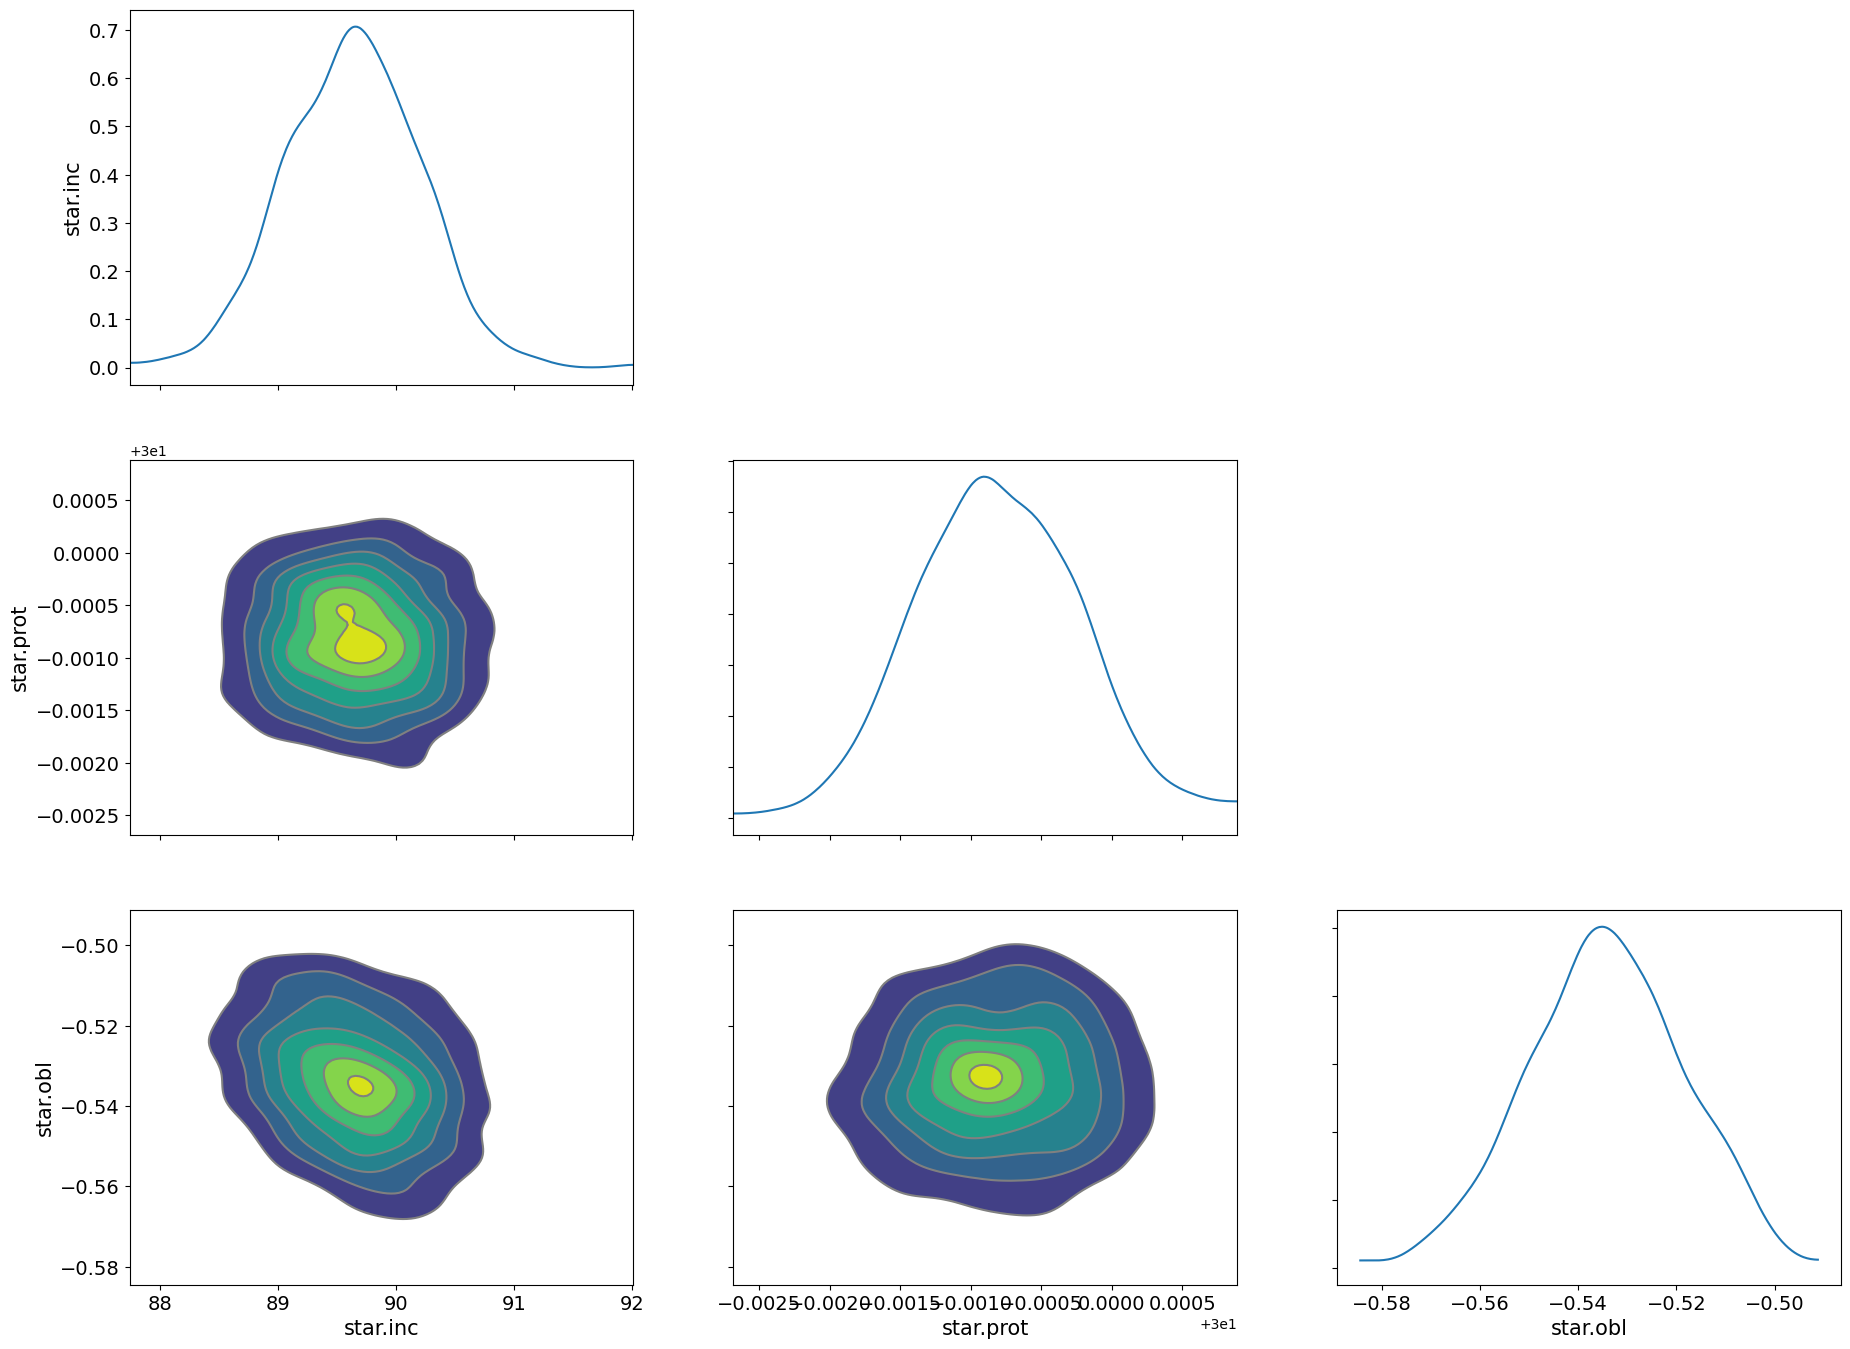

In [90]:
az.plot_pair(trace, var_names=['star.inc',
 'star.prot',
 'star.obl'], kind='kde', marginals=True)

In [91]:
az.to_netcdf(trace,'SSP-Sabina-planet-star.nc')

Got error No model on context stack. trying to find log_likelihood in translation.


'SSP-Sabina-planet-star.nc'

In [99]:
# Set some free params & get the model
p = dict(params)

p['star.prot']['free'] = True
p['star.obl']['free'] = True
p['star.inc']['free'] = True
p['planet.porb']['free'] = True
p['planet.t0']['free'] = True
p['planet.r']['free'] = True
p['planet.inc']['free'] = True
p['gp.c']['free'] = True
p['gp.mu']['free'] = True
p['gp.sigma']['free'] = True
p['gp.r']['free'] = True

free = [x for x in p.keys() if p[x].get("free", False)]
model = gp_model(t, flux_obs, sigma_flux, p)

In [100]:
free

['planet.inc',
 'planet.porb',
 'planet.t0',
 'planet.r',
 'star.inc',
 'star.prot',
 'star.obl',
 'gp.r',
 'gp.c',
 'gp.mu',
 'gp.sigma']

In [101]:
# Optimize
with model:
    map_soln = pmx.optimize()
    for x in free:
        print(f"{x}: {map_soln[x]} {[params[x]['truth']]}")


planet.inc: 89.98685343432757 [90.0]
planet.porb: 4.887804109729742 [4.887802443]
planet.t0: -2.1966017128033366e-05 [0.0]
planet.r: 0.027232018526935853 [0.027320000000000004]
star.inc: 90.0 [90]
star.prot: 29.999189445992364 [30]
star.obl: -0.5357743959351501 [-30]
gp.r: 19.836938596638355 [20]
gp.c: 0.46467149644359473 [0.5]
gp.mu: 29.659888877544955 [30]
gp.sigma: 4.345691184484596 [5]


message: Desired error not necessarily achieved due to precision loss.
logp: 12223.638839742101 -> 12248.056539453717


In [102]:
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        chains=1,
        cores=4,
        target_accept=0.9,
        return_inferencedata=False,
    )

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 20397 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


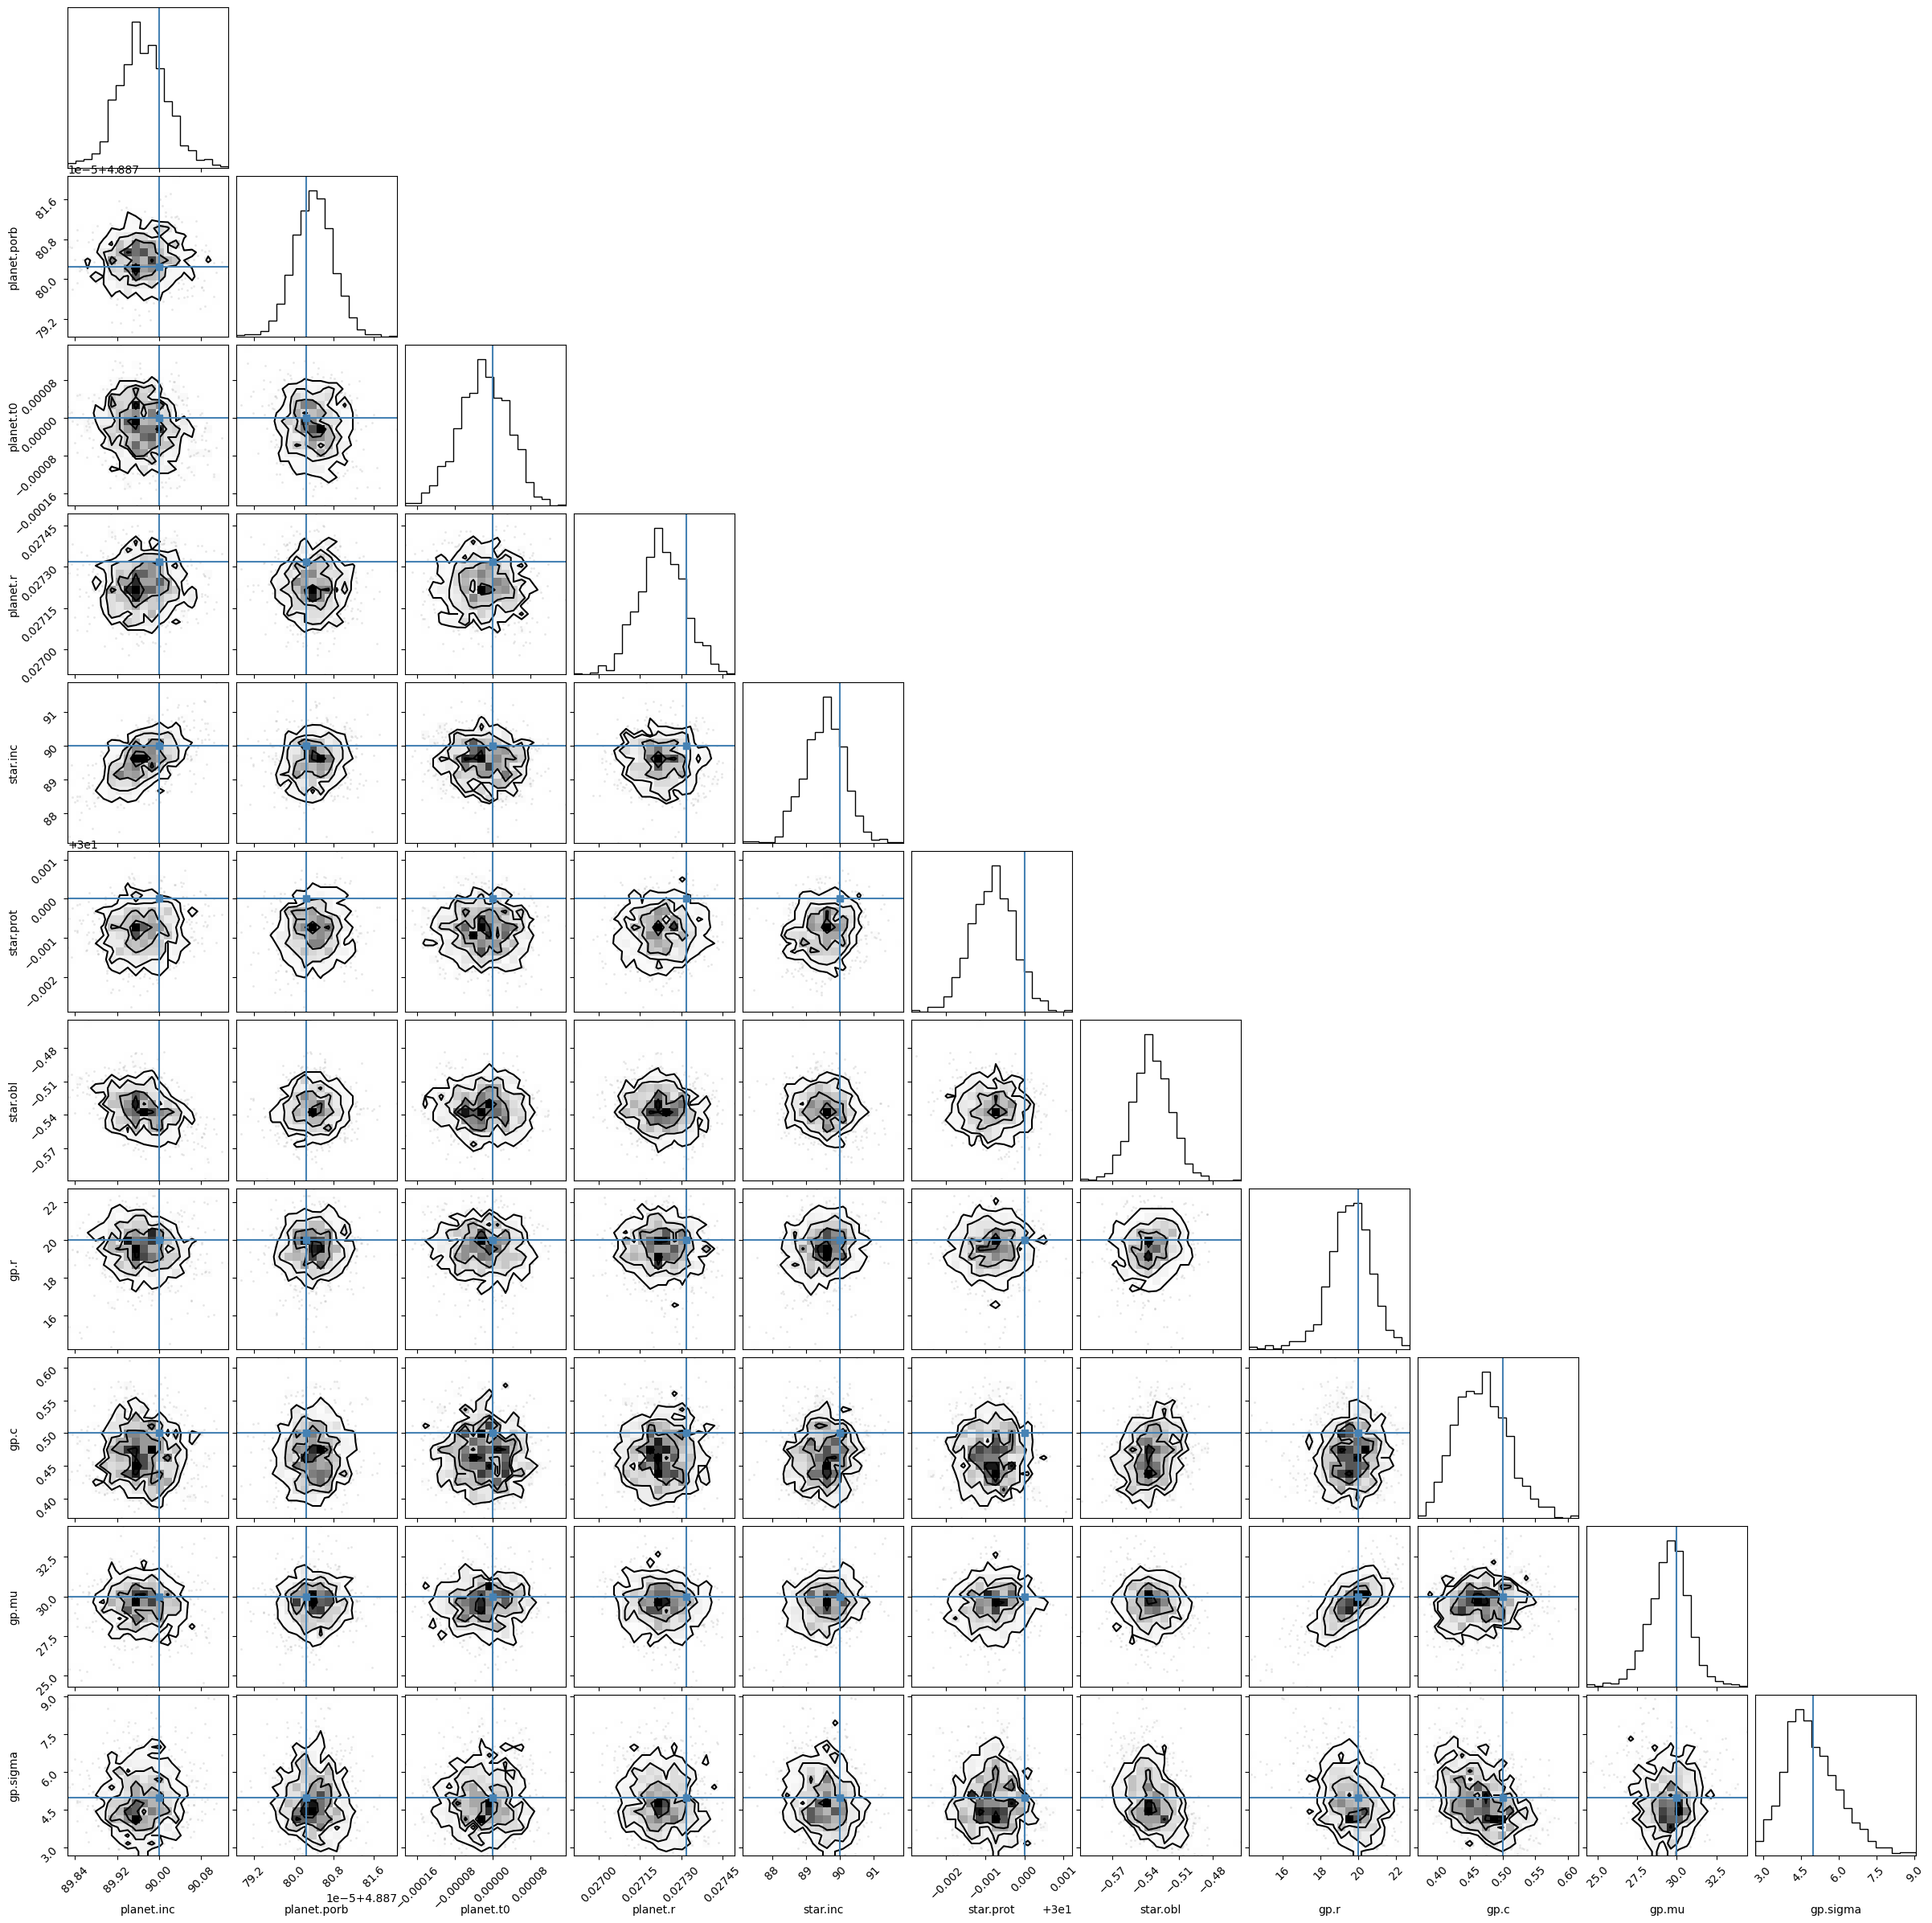

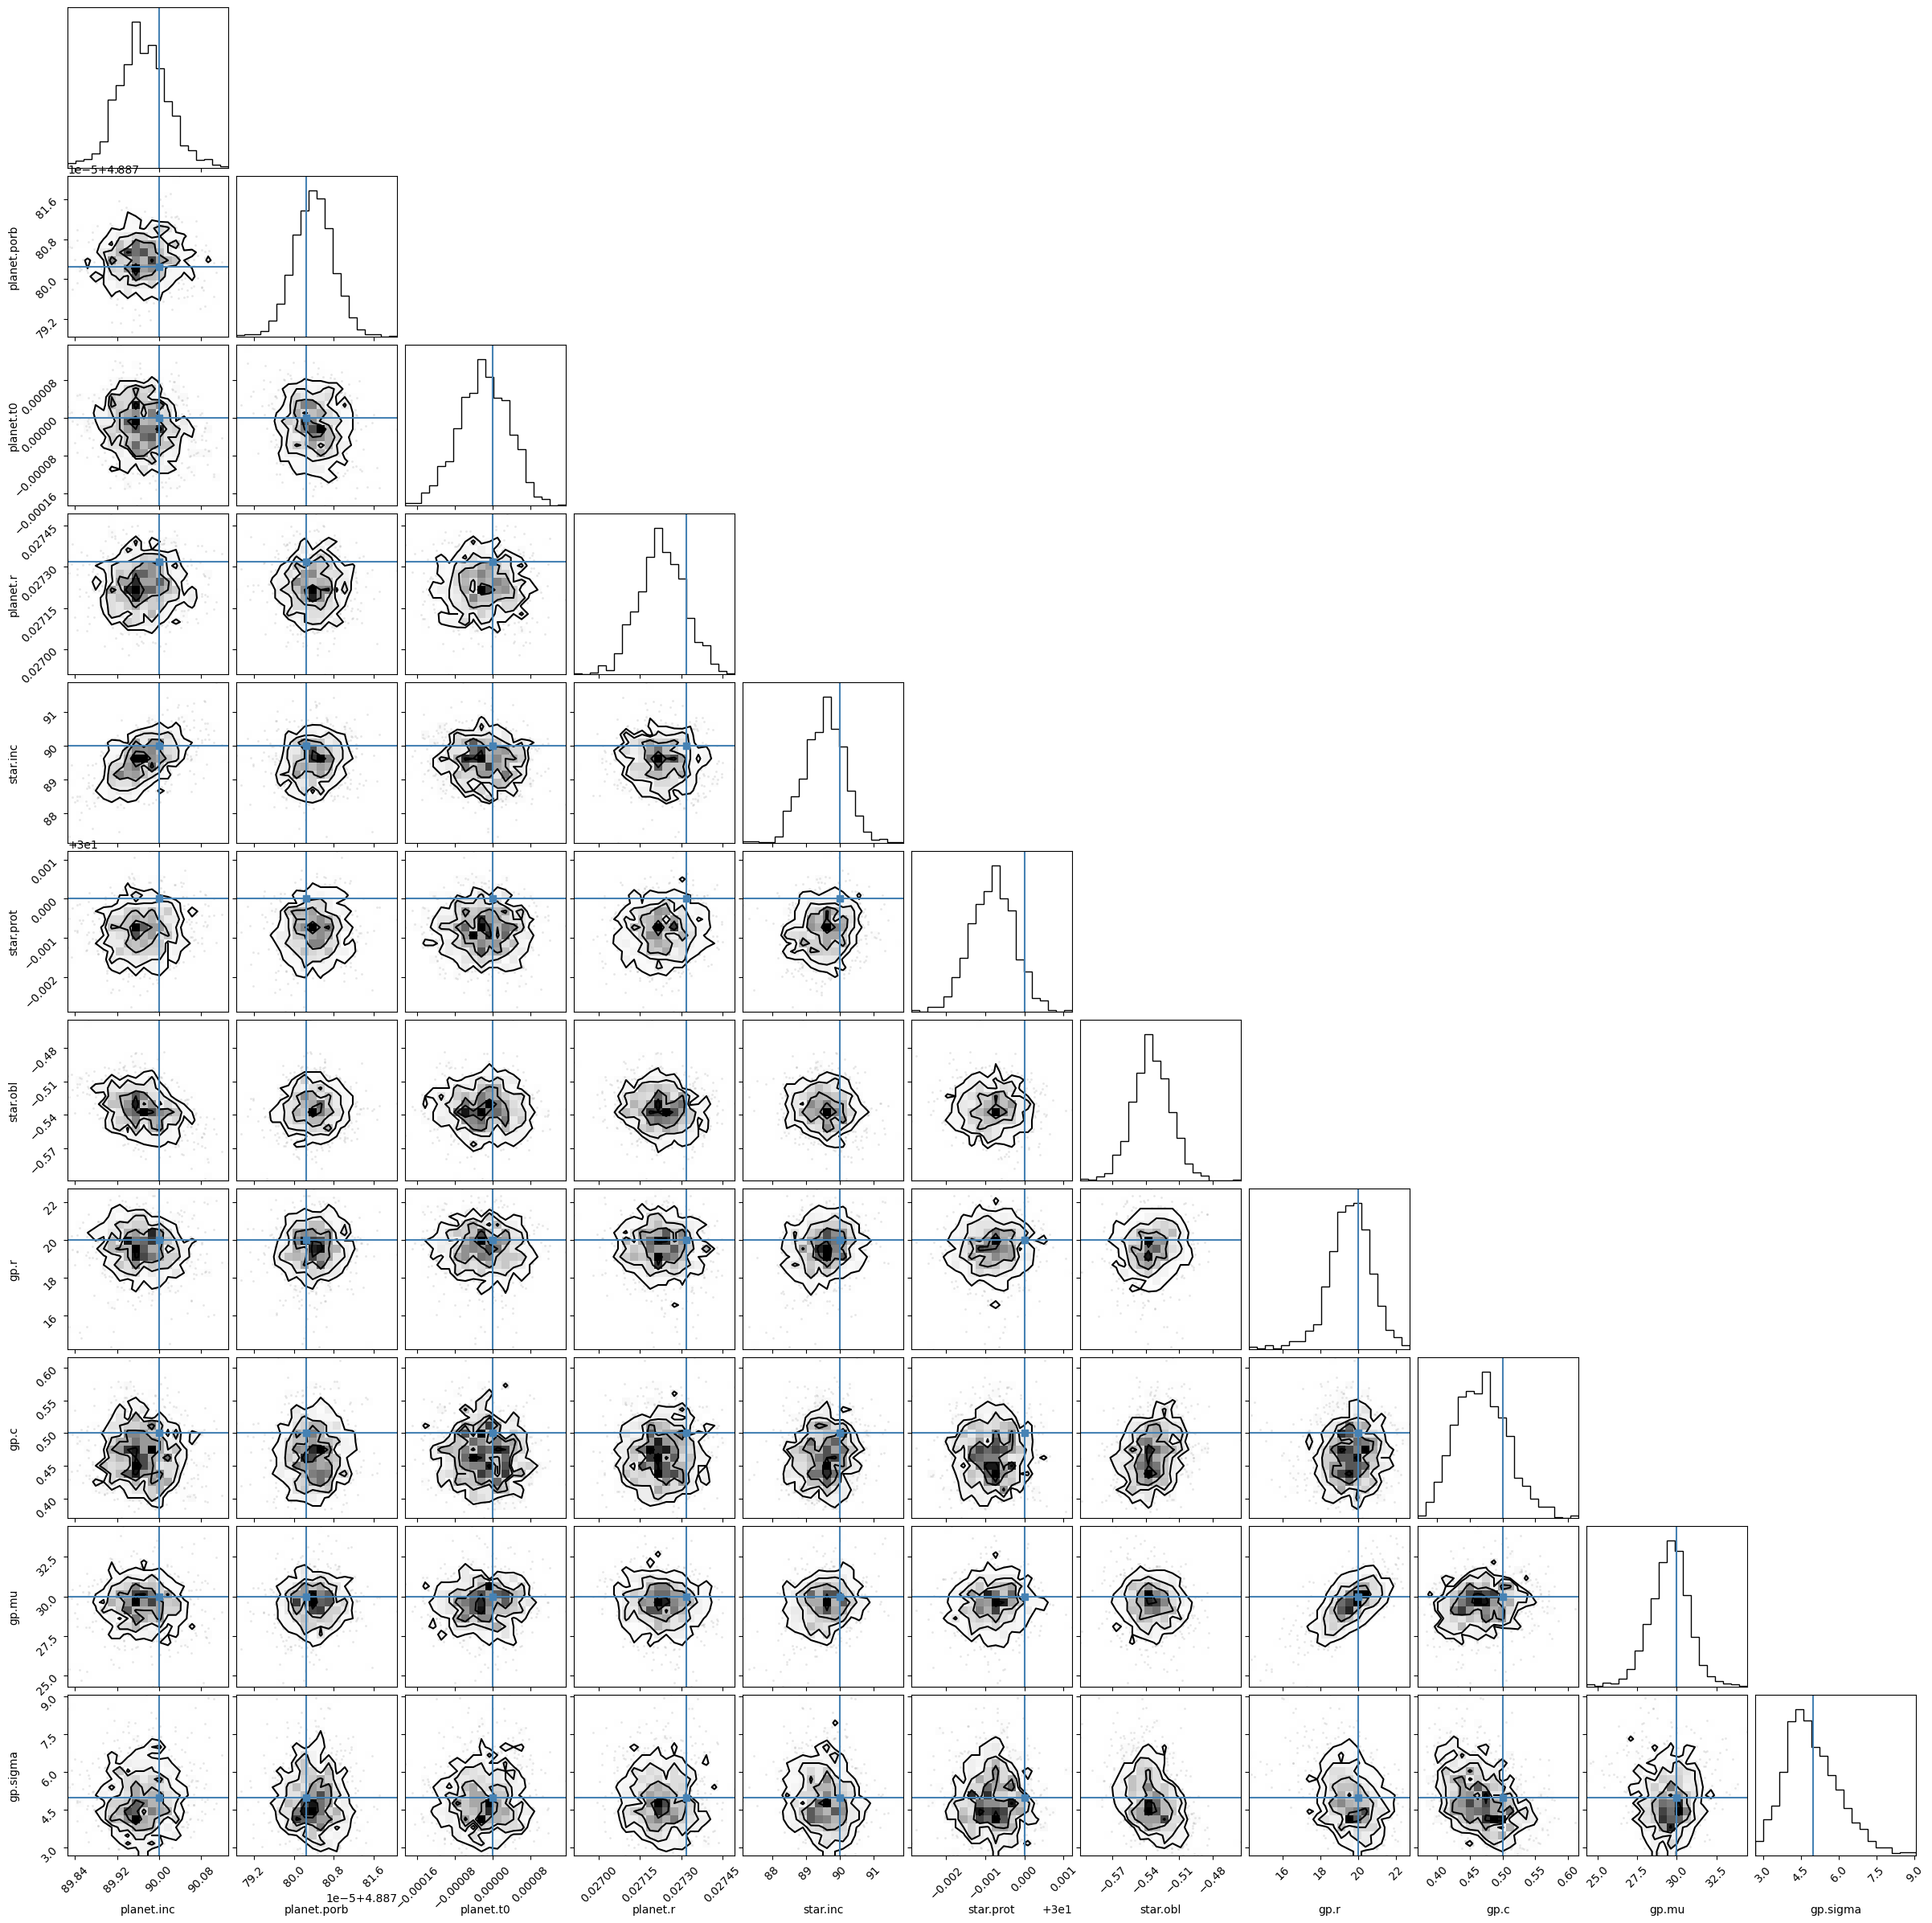

In [103]:
samples = pm.trace_to_dataframe(trace,varnames=free)
corner(np.array(samples),labels=free,truths=[params[x]['truth'] for x in free])

In [104]:
az.to_netcdf(trace,'SSP-Sabina-planet-star-gp.nc')

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/envs/starry-test/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


'SSP-Sabina-planet-star-gp.nc'

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/envs/starry-test/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/opt/anaconda3/envs/starry-test/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='planet.inc'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='planet.porb'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='planet.t0'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='planet.r'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='star.inc'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='star.prot'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='star.obl'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='planet.inc', ylabel='gp.r'>,
        <Axes: xlabel='planet.porb'>, <Axes: xlabel='planet.t0'>,
        <Axes: xlabel='planet.r'>, <Axes: xlabel='star.inc'>,
        <Axes: 

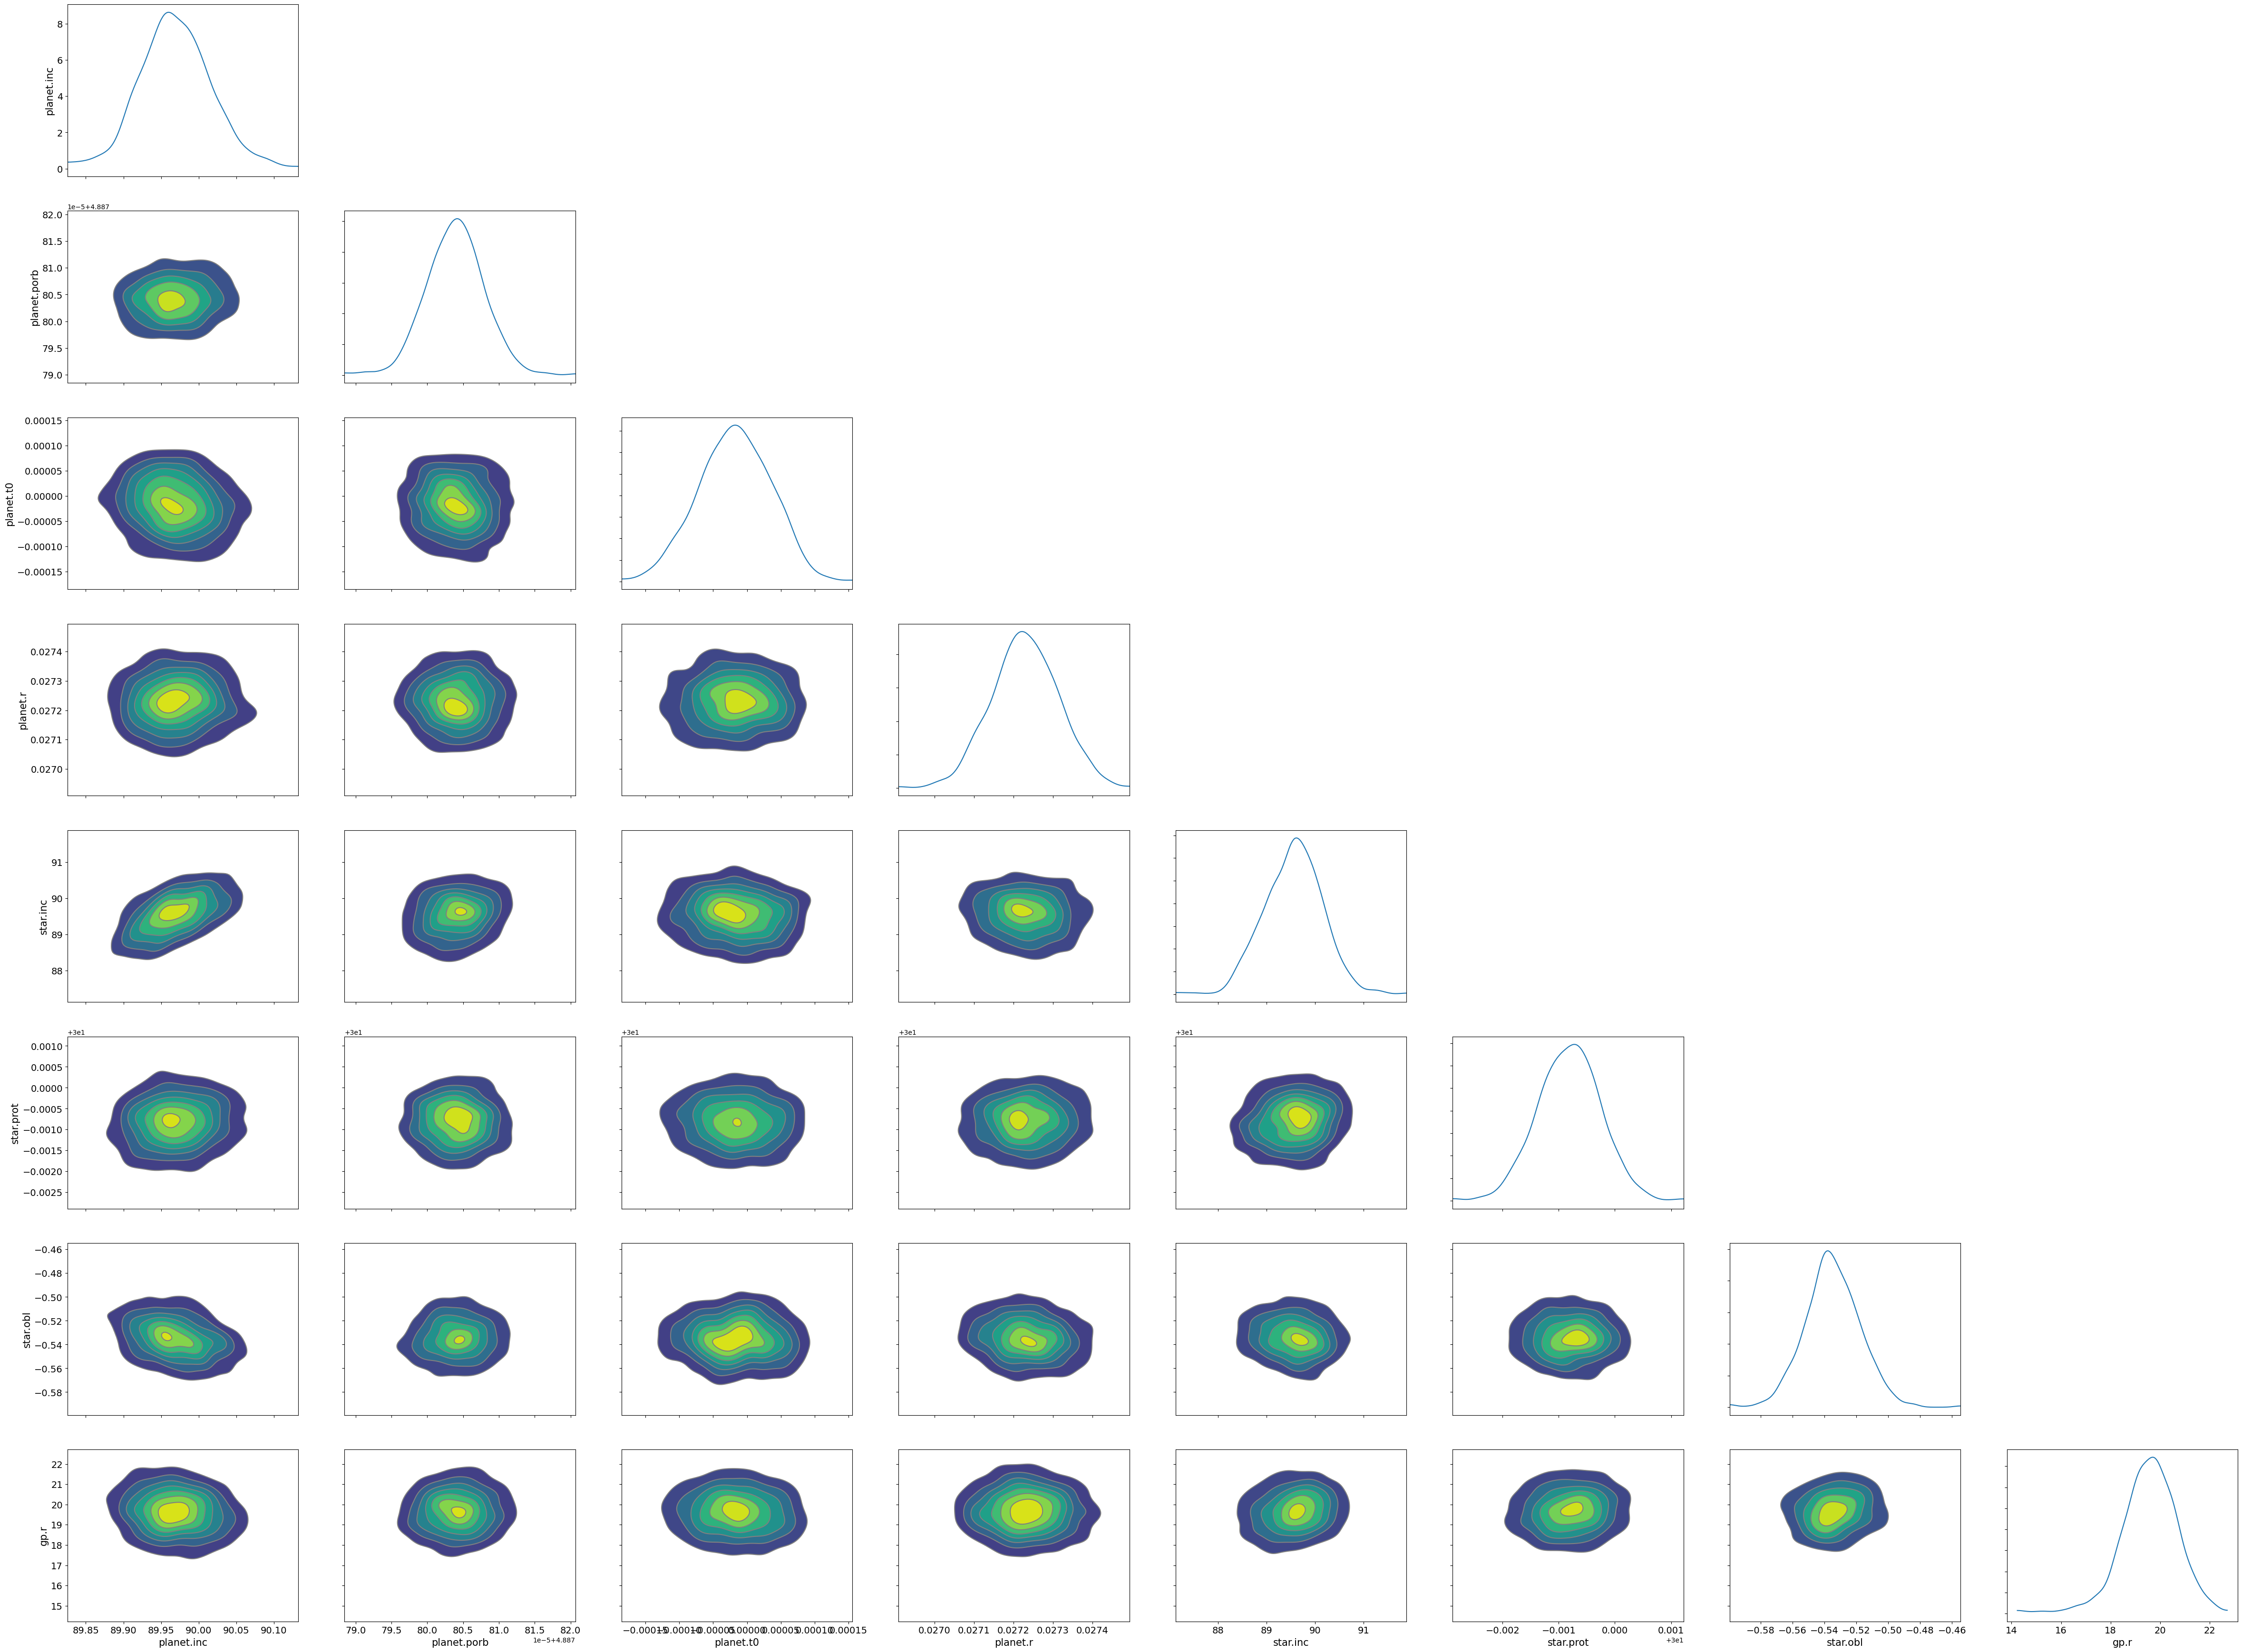

In [105]:
az.plot_pair(trace, var_names=free, kind='kde', marginals=True)

In [106]:
lat, lon, Y2P, P2Y, Dx, Dy = map.get_pixel_transforms(oversample=2)

In [107]:
cov_pix = sp.cov_pix(latlon=np.concatenate((lon, lat)).reshape(len(lon),2, order='F')).eval()

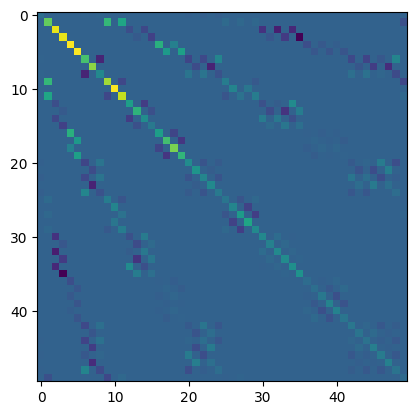

In [118]:
plt.imshow(sp.cov_ylm.eval()[:50,:50])

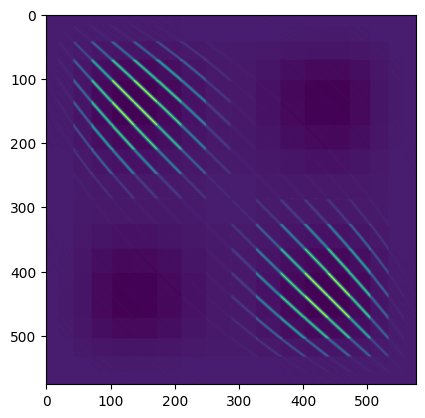

In [122]:
plt.imshow(tt.dot(tt.dot(Y2P, sp.cov_ylm.eval()), Y2P.T).eval())

In [126]:
cov_pix = tt.dot(tt.dot(Y2P, sp.cov_ylm.eval()), Y2P.T).eval()

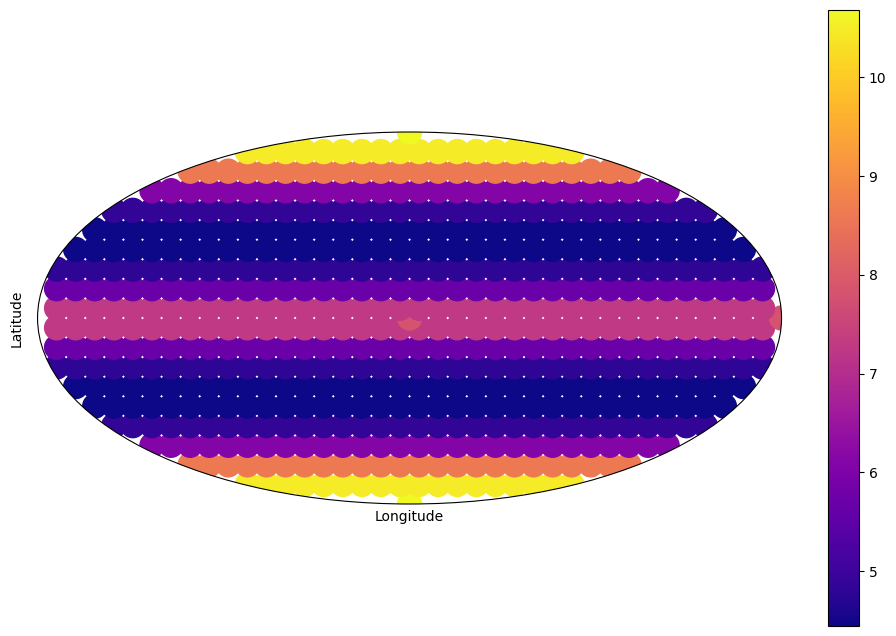

In [128]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='mollweide')
cax = ax.scatter(np.deg2rad(lon), np.deg2rad(lat), c=np.log(np.diag(1/cov_pix)), s=300, cmap='plasma')
# ax.grid(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_yticklabels([])
ax.set_xticklabels([])
cbar = fig.colorbar(cax, orientation='vertical')
plt.show()

In [182]:
flux_true

array([1.00787819, 0.99860138, 0.99489091, ..., 1.01330454, 1.01330259,
       1.01284109])

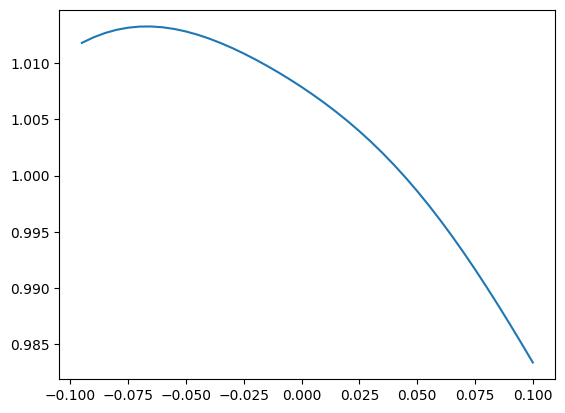

In [180]:
plt.plot(t[sel], flux[sel])
# plt.xlim(-5,5)

In [139]:
rand_index = np.random.randint(0,samples.shape[0])

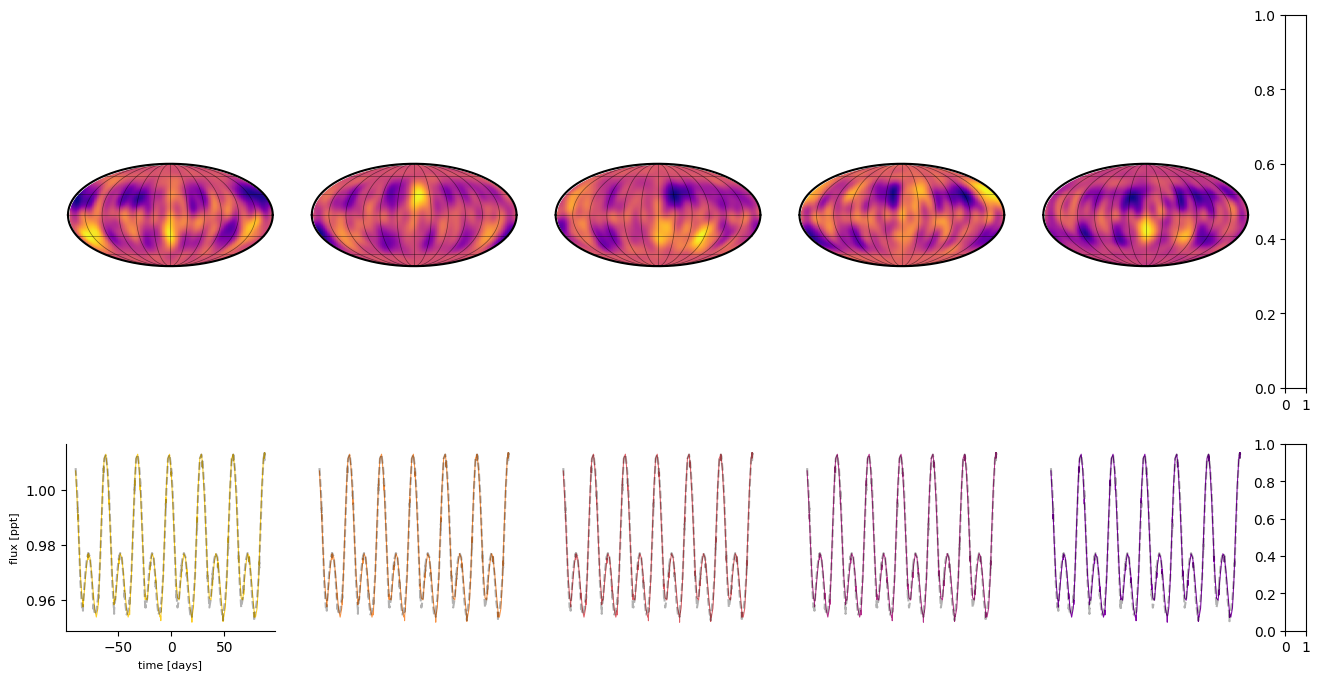

In [239]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from starry_process import StarryProcess
import starry
import os
from tqdm import tqdm

nsamples = 5
norm = Normalize(vmin=0.5, vmax=1.1)
cmap = plt.get_cmap("plasma_r")
color = lambda i: cmap(0.1 + 0.8 * i / (len(incs) - 1))

fig, ax = plt.subplots(
    2,
    nsamples+1,
    figsize=(16, 8),
    gridspec_kw={
        "height_ratios": np.tile([1, 0.5], 1),
        "width_ratios": np.append(np.ones(nsamples), 0.1),
    },
)


for k in range(nsamples):
    rand_index = np.random.randint(0,samples.shape[0])
    map_samples = starry.Map(15, 2)
    star = starry.Primary(map, r=params["star.r"]["truth"], m=params["star.m"]["truth"], prot=samples["star.prot"][rand_index]) 
    planet = starry.Secondary(
        starry.Map(0,0),
        inc=samples["planet.inc"][rand_index],
        ecc=params["planet.ecc"]["truth"],
        Omega=params["planet.Omega"]["truth"],
        porb=samples["planet.porb"][rand_index],
        t0=samples["planet.t0"][rand_index],
        r=samples["planet.r"][rand_index],
        m=params["planet.m"]["truth"],
        prot=1.0
    )

    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]
    theta = (360 * t / params["star.prot"]["truth"]) % 360
    
    sp_samples = StarryProcess(
        mu=samples["gp.mu"][rand_index],
        sigma=samples["gp.sigma"][rand_index],
        r=samples["gp.r"][rand_index],
        dr=params["gp.dr"]["truth"],
        c=samples["gp.c"][rand_index],
        n=params["gp.n"]["truth"],
    )

    nt = len(t)
    ssp_samples = StarryStarryProcess(sys, sp_samples, nt, len(star.map.y.eval()))

    ylm_samples = ssp_samples.sample_ylm_conditional(t, flux_obs, sigma_flux).eval()[0,:]

    map_samples[:, :] = ylm_samples.reshape(-1)
    map_samples.show(ax=ax[0, k], projection="moll")
    ax[0, k].set_ylim(-1.5, 2.25)
    ax[0, k].set_rasterization_zorder(1)
    flux_samples = sys.design_matrix(t).eval()[:, :-1] @ ylm_samples
    ax[1, k].plot(t, flux_samples, color=color(k), lw=0.75)
    ax[1, k].plot(t, flux_true, 'k--', alpha=0.3)
    # ax[1, k].set_xlim(-30,30)

    if k == 0:
        ax[1, k].spines["top"].set_visible(False)
        ax[1, k].spines["right"].set_visible(False)
        ax[1, k].set_xlabel("time [days]", fontsize=8)
        ax[1, k].set_ylabel("flux [ppt]", fontsize=8)
    else:
        ax[1, k].axis("off")


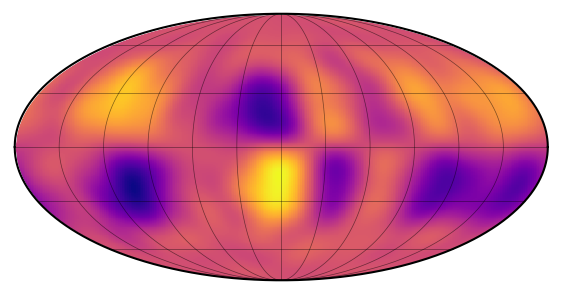

In [186]:
map_inf = starry.Map(ydeg=15, udeg=2)
map_inf[:,:] = ylm_draw.reshape(-1)
map_inf.show(projection="moll")

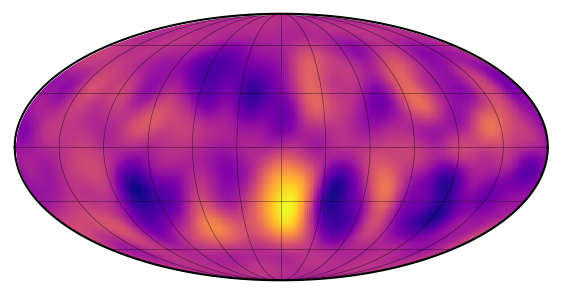

In [232]:
map = starry.Map(ydeg=15, udeg=2)
map[:,:] = y_true.reshape(-1)
map.show(projection="moll")

Text(0, 0.5, 'flux')

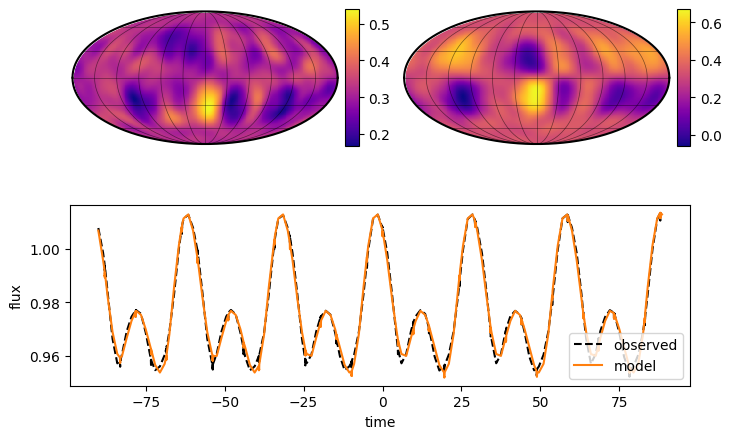

In [236]:
from matplotlib import colors
cmap = plt.get_cmap("plasma")
cmap.set_under("#666666")
cmap.set_over("w")
cnorm = lambda: colors.Normalize(vmin=0.0)
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=0.15)
ax = [
    plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=1),
    plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=1),
    plt.subplot2grid((3, 2), (1, 0), colspan=2, rowspan=1),
]

# Show the true map
map.show(
    ax=ax[0],
    projection="moll",
    colorbar=True,
    #norm=cnorm()
)

# Show the inferred map
map_inf.show(
    ax=ax[1],
    projection="moll",
    colorbar=True,
    #norm=cnorm()
)

# Show the flux model
ax[2].plot(t, flux_obs, "k--", alpha=1, label="observed")
ax[2].plot(t, flux, "C1", label="model")
ax[2].legend(fontsize=10, loc="lower right")
ax[2].set_xlabel("time")
ax[2].set_ylabel("flux")
# ax[2].set_xlim(-0.1, 0.1)
# ax[2].set_ylim(0.98, 1.02)